In [4]:
import os
import pickle, bz2

import tqdm
from bokeh.io import output_notebook, show


In [5]:
# loader
def load_dataset(file_path):
    with bz2.BZ2File(file_path, 'rb') as f:
        dataset = pickle.load(f)
    return dataset

def print_dataset_structure(dataset_dict, name=None):
    first_level_keys = set()
    second_level_keys = set()
    third_level_keys = set()



    for key, value in dataset_dict.items():
        first_level_keys.add(key)
        if isinstance(value, dict):
            for sub_key in value.keys():
                second_level_keys.add(sub_key)
                if isinstance(value[sub_key], dict):
                    for sub_sub_key in value[sub_key].keys():
                        third_level_keys.add(sub_sub_key)

    if name is not None:
        print(f"Dataset Structure for Dataset: {name}")
    else:
        print("Dataset Structure:")


    print("----"*10)
    print("First Level Keys:")
    print(first_level_keys)
    print("----"*10)
    print("Second Level Keys:")
    print(list(second_level_keys)[:10])
    print("----"*10)
    print("Third Level Keys:")
    print(third_level_keys)
    print("----"*10)
    print("\n")

def print_all_datasets_structure(dataset_path_list):
    for dataset_pkl in dataset_pkls:
        dataset_path = os.path.join(data_dir, dataset_pkl)
        dataset_dict = load_dataset(dataset_path)
        print_dataset_structure(dataset_dict, name=dataset_pkl)
        del dataset_dict

# get all split_n_bar_phrases from last key
def get_split_n_bar_phrases(dataset_path_list):
    if not isinstance(dataset_path_list, list):
        dataset_path_list = [dataset_path_list]

    split_n_bar_phrases = list()

    for dataset_pkl_ in dataset_path_list:
        dataset_dict_ = load_dataset(os.path.join(data_dir, dataset_pkl_))
        for key, value in dataset_dict_.items():
            for sub_key, sub_value in value.items():
                hvo_splits = sub_value['split_n_bar_phrases']
                for hvo_split in hvo_splits:
                    hvo_split.metadata.update({'collection': dataset_pkl_.replace('.pkl.bz2', ''), 'sample_id': sub_key})

                split_n_bar_phrases.extend(sub_value['split_n_bar_phrases'])

    return split_n_bar_phrases

import random

def get_randome_phrases(split_n_bar_phrases, n=1):
    # returns hvos and their indexes in the split_n_bar_phrases list
    if not isinstance(split_n_bar_phrases, list):
        split_n_bar_phrases = [split_n_bar_phrases]
    sample_ix = random.sample(range(len(split_n_bar_phrases)), n)
    sample_hvo_phrases = [split_n_bar_phrases[ix] for ix in sample_ix]

    return sample_hvo_phrases, sample_ix




from bokeh.models import Tabs, TabPanel
import warnings
import logging
from bokeh.util.warnings import BokehUserWarning, BokehDeprecationWarning

def setup_quiet_bokeh():
    """Set up comprehensive bokeh warning suppression"""
    # Suppress warnings
    warnings.filterwarnings("ignore", category=BokehUserWarning)
    warnings.filterwarnings("ignore", category=BokehDeprecationWarning)
    warnings.filterwarnings("ignore", message=".*bokeh.*")

    # Suppress logging
    logging.getLogger('bokeh').setLevel(logging.ERROR)

    # Suppress other common warnings that might appear with bokeh
    warnings.filterwarnings("ignore", category=FutureWarning)
    warnings.filterwarnings("ignore", category=UserWarning)

def create_multitab_from_figures(hvos,  tab_titles=None, show_tabs= True):
    """
    Create a multitab visualizer from already-generated bokeh figures.

    Parameters:
    -----------
    figures : List
        List of bokeh figure objects
    tab_titles : List[str]
        List of titles for each tab
    show_tabs : bool, default=True
        Whether to immediately show the tabs

    Returns:
    --------
    Tabs
        Bokeh Tabs object containing all the figures
    """
    setup_quiet_bokeh()
    output_notebook()

    figures = []

    generate_titles = False
    if tab_titles is None:
        tab_titles = []
        generate_titles = True

    if not isinstance(hvos, list):
        hvos = [hvos]
    for ix, hvo in enumerate(hvos):
        figure = hvo.to_html_plot(
            filename='',
            save_figure=False,
            show_figure=False)
        figures.append(figure)
        if generate_titles:
            tab_titles.append(f"Tab {ix+1}")

    if not isinstance(tab_titles, list):
        tab_titles = [tab_titles]
    if not tab_titles:
        tab_titles = [f"Tab {i+1}" for i in range(len(figures))]
    if len(figures) == 0:
        raise ValueError("No figures provided to create tabs")

    if len(figures) != len(tab_titles):
        raise ValueError("Number of figures must match number of tab titles")

    panels = []

    for figure, title in zip(figures, tab_titles):
        panel = TabPanel(child=figure, title=title)
        panels.append(panel)

    tabs = Tabs(tabs=panels)

    if show_tabs:
        show(tabs)

    return tabs




In [118]:
import numpy as np

def get_accent_hits_from_velocities(velocity_flat, accent_thresh=0.6):
    """
    Extract accent hits from the velocity flat representation of HVO.
    :param velocity_flat: a (B, T, 1) or (T, 1) numpy array where the last  column represents the velocity of hits.
    :param use_median: if True, use the median velocity to determine accent hits, otherwise use 0.75
    :return:
    """
    assert velocity_flat.ndim == 1 or velocity_flat.shape[-1] == 1, "Velocity flat must have 1 columns (hits, velocity, offset)"
    return np.where(velocity_flat > accent_thresh, 1, 0)

def get_split_to_streams(hvo_sample, groove_dim=0):
    """
    Split the HVO sample into input groove, streams, and flat output HVO.

    Parameters:
    -----------
    hvo_sample : HVOSequence
        The HVO sample to be split.
    groove_dim : int, optional
        The index of the groove dimension in the HVO sample. Default is 0.

    Returns:
    --------
    input_hvo : HVOSequence
        The input groove extracted from the HVO sample.
    streams : list of HVOSequence
        List of streams extracted from the HVO sample, excluding the groove dimension.
    flat_out_hvo : HVOSequence
        The flat output HVO sequence with the groove dimension set to zero.
    """
    # get input groove
    n_streams = hvo_sample.hits.shape[1]

    input_hvo = hvo_sample.hvo[:, (groove_dim, groove_dim+n_streams, groove_dim+2*n_streams)]

    # get flat of rest
    flat_hvo = hvo_sample.copy()
    flat_hvo.hvo[:, groove_dim] = 0                             # remove groove hit
    flat_hvo.hvo[:, (groove_dim + n_streams)] = 0               # remove groove vel
    flat_hvo.hvo[:, (groove_dim + n_streams*2)] = 0             # remove groove offset
    flat_out_hvo  = flat_hvo.flatten_voices(reduce_dim=True)

    # streams
    streams = []
    for i in range(n_streams):
        if i != groove_dim:
            streams.append(hvo_sample.hvo[:, (i, i+n_streams, i+2*n_streams)])

    return input_hvo, streams, flat_out_hvo

def Jaccard_similarity(a, b):
    intersection = np.sum(np.minimum(a, b))
    union = np.sum(np.maximum(a, b))
    return (intersection / union)

def hamming_distance(a, b):
    if len(a) != len(b):
        raise ValueError("Sequences must be of equal length")
    return sum(x != y for x, y in zip(a, b))/ len(a)

from hvo_sequence.utils import fuzzy_Hamming_distance

def extract_features_from_sets(hvo_sample, groove_dim):
    """
    Extract control features from a set of HVO samples.
    :param hvo_sample: HVOSequence
        The HVO sample to extract control features from.
    :param groove_dim: int
        The index of the groove dimension in the HVO sample.
    :return: dict
        A dictionary containing the control features.
    """
    input_hvo, out_streams, flat_out_hvo = get_split_to_streams(hvo_sample, groove_dim=groove_dim)

    input_hits = input_hvo[:, 0]
    flat_out_hits = flat_out_hvo[:, 0]
    analysis_dict = {
        "groove_to_output_hit_hamming_distance": float(hamming_distance(input_hits, flat_out_hits)),
    }

    input_velocities = input_hvo[:, 1]
    input_accent_hits = get_accent_hits_from_velocities(input_velocities)
    flat_out_velocities = flat_out_hvo[:, 1]
    flat_out_accent_hits = get_accent_hits_from_velocities(flat_out_velocities)
    analysis_dict.update({
        "groove_to_output_accent_hamming_distance": float(hamming_distance(input_accent_hits, flat_out_accent_hits)),
    })

    # calculate hit
    analysis_dict.update({f"out_stream_{i}_jaccard_sim_with_flat_out": float(Jaccard_similarity(out_streams[i][:, 0], flat_out_hits)) for i in range(len(out_streams))})
    analysis_dict.update({f"out_stream_{i}_accent_hamming_distance_with_flat_out": float(hamming_distance(get_accent_hits_from_velocities(out_streams[i][:, 1]), flat_out_accent_hits)) for i in range(len(out_streams))})


    return analysis_dict

# plot violin plots of the control features
import seaborn as sns
import matplotlib.pyplot as plt
def plot_control_features_violin(control_features_df):
    """
    Plot violin plots of the control features.
    :param control_features_df: pd.DataFrame
        DataFrame containing the control features.
    """
    plt.figure(figsize=(6, 8))
    sns.violinplot(data=control_features_df.drop(columns=["sample_id", "collection"]))
    # 90 deg rotate with wrapp
    plt.xticks(rotation=90, fontsize=8)
    plt.title("Control Features Violin Plots")
    plt.tight_layout()


    plt.show()

# plot the  scatter of groove to output hit hamming distance and groove to output accent hamming distance
def plot_scatter_input_output_distribution(control_features_df, use_normalized_accents=False):
    plt.figure(figsize=(6, 4))
    x = control_features_df["groove_to_output_hit_hamming_distance"]
    y = control_features_df["groove_to_output_accent_hamming_distance"] if not use_normalized_accents else control_features_df["accent_hamming_values_per_hit_hamming_normalized"]
    plt.scatter(x, y, alpha=0.01)
    plt.xlabel("Groove to Output Hit Hamming Distance")
    plt.ylabel("Groove to Output Accent Hamming Distance")
    plt.title("Scatter Plot of Groove to Output Hit and Accent Hamming Distances")
    plt.tight_layout()
    plt.show()




looking only at lmd to see if accent hamming gets better

In [90]:
# LOAD DATASETS

data_dir = "data/triple_streams/split_2bars/lmd_top_four" # "data/triple_streams/split_2bars/lmd"

# find all .pkl.bz2 files in the directory
dataset_pkls = [f for f in os.listdir(data_dir)[:20] if f.endswith('.pkl.bz2')]

# print the structure of each dataset
print_all_datasets_structure(dataset_pkls)

# load all loops from all datasets
split_n_bar_phrases = get_split_n_bar_phrases(dataset_pkls)

# print the number of phrases loaded
print(f"Number of split_n_bar_phrases loaded: {len(split_n_bar_phrases)}")

Dataset Structure for Dataset: lmd_batch_56_filtered.pkl.bz2
----------------------------------------
First Level Keys:
{'AllAvailableStreams'}
----------------------------------------
Second Level Keys:
['32e399752c24139e6e3f31643d353517', '2e807652ae5d11defa5089962dc3899b', '47e245ee4a35a55a5641ed975604d5db', '7a29a53990f69b6018a05ae1b7119b6e', '9e37e5c264a24135e19b056b7ac8202a', '265aa7ef53c02f11d70aaca0b70da568', '510aeb6201edab710269485bc2a36612', '051a2e917414e59956aad890d32b268c', 'e49d8d132dc86228e529b2ba378bf4b2', '63aa15ea6292ff787a286893f75ec32e']
----------------------------------------
Third Level Keys:
{'split_n_bar_phrases', 'filenames', 'hvo_sequences', 'compiled_single_hvos'}
----------------------------------------


Dataset Structure for Dataset: lmd_batch_33_filtered.pkl.bz2
----------------------------------------
First Level Keys:
{'AllAvailableStreams'}
----------------------------------------
Second Level Keys:
['682251bd46b4f1560d8cc1f14024a37b', '323c60b427e86

In [98]:
# Extract control features for all samples
control_features = {
    "sample_id": [],
    "collection": [],
}
# control_features_static_groove = {
#     "sample_id": [],
#     "collection": [],
# }
import tqdm

for hvo_sample in tqdm.tqdm(split_n_bar_phrases):
    for groove_dim in range(4): #<--- change to 1 if you don't want to use all streams as a groove (TODO: Change and generate different plots)
        control_features["sample_id"].append(hvo_sample.metadata['sample_id'])
        control_features["collection"].append(hvo_sample.metadata['collection'])

        features = extract_features_from_sets(hvo_sample, groove_dim)
        for key, value in features.items():
            if key not in control_features:
                control_features[key] = []
            control_features[key].append(value)

### Same as above, but remove the range(4) -> keeps groove static
### using this for comparisons
# for hvo_sample in tqdm.tqdm(split_n_bar_phrases):
#     for groove_dim in range(1): #<--- change to 1 if you don't want to use all streams as a groove (TODO: Change and generate different plots)
#         control_features_static_groove["sample_id"].append(hvo_sample.metadata['sample_id'])
#         control_features_static_groove["collection"].append(hvo_sample.metadata['collection'])

#         features = extract_features_from_sets(hvo_sample, groove_dim)
#         for key, value in features.items():
#             if key not in control_features_static_groove:
#                 control_features_static_groove[key] = []
#             control_features_static_groove[key].append(value)


# Convert to DataFrame
import pandas as pd
control_features_df = pd.DataFrame(control_features)
control_features_df


# control_features_static_groove_df = pd.DataFrame(control_features_static_groove)
# control_features_static_groove_df

  1%|          | 1113/113624 [00:01<01:46, 1056.27it/s]/var/folders/1b/mwwqz1l90n9_6fdy5008r1wr0000gn/T/ipykernel_85012/1165965975.py:56: RuntimeWarning:

invalid value encountered in scalar divide

100%|██████████| 113624/113624 [01:39<00:00, 1140.17it/s]


,sample_id,collection,groove_to_output_hit_hamming_distance,groove_to_output_accent_hamming_distance,out_stream_0_jaccard_sim_with_flat_out,out_stream_1_jaccard_sim_with_flat_out,out_stream_2_jaccard_sim_with_flat_out,out_stream_0_accent_hamming_distance_with_flat_out,out_stream_1_accent_hamming_distance_with_flat_out,out_stream_2_accent_hamming_distance_with_flat_out
0,4c15eca6bb1f673da443ffb105aaf147,lmd_batch_56_filtered,0.18750,0.21875,0.250000,1.000000,0.500000,0.37500,0.00000,0.25000
1,4c15eca6bb1f673da443ffb105aaf147,lmd_batch_56_filtered,0.40625,0.37500,0.705882,0.941176,0.470588,0.21875,0.00000,0.25000
2,4c15eca6bb1f673da443ffb105aaf147,lmd_batch_56_filtered,0.12500,0.12500,0.857143,0.285714,0.571429,0.09375,0.25000,0.12500
3,4c15eca6bb1f673da443ffb105aaf147,lmd_batch_56_filtered,0.28125,0.25000,0.705882,0.235294,0.941176,0.21875,0.37500,0.00000
4,4c15eca6bb1f673da443ffb105aaf147,lmd_batch_56_filtered,0.21875,0.18750,0.250000,1.000000,0.500000,0.37500,0.00000,0.25000
...,...,...,...,...,...,...,...,...,...,...
454491,195307b6ca57287d544a14cefe0648d1,lmd_batch_13_filtered,0.00000,0.06250,0.000000,1.000000,0.812500,0.43750,0.12500,0.03125
454492,195307b6ca57287d544a14cefe0648d1,lmd_batch_13_filtered,0.00000,0.18750,0.250000,0.687500,1.000000,0.37500,0.15625,0.00000
454493,195307b6ca57287d544a14cefe0648d1,lmd_batch_13_filtered,0.37500,0.37500,1.000000,0.687500,1.000000,0.18750,0.15625,0.00000
454494,195307b6ca57287d544a14cefe0648d1,lmd_batch_13_filtered,0.15625,0.15625,1.000000,0.250000,1.000000,0.18750,0.37500,0.00000


In [99]:
import numpy as np
# box plot import

# get unique hit hamming distances
hit_hamming_values = sorted(set(control_features_df["groove_to_output_hit_hamming_distance"].values))
print(hit_hamming_values)
accent_hamming_values_per_hit_hamming = {float(hit_hamming_value): [] for hit_hamming_value in hit_hamming_values}
for key in accent_hamming_values_per_hit_hamming.keys():
    accent_hamming_values_per_hit_hamming[key] = control_features_df[control_features_df["groove_to_output_hit_hamming_distance"] == key].groove_to_output_accent_hamming_distance.values
    # get box plot stats
    lower_bound = np.sort(accent_hamming_values_per_hit_hamming[key])[10]
    upper_bound = np.sort(accent_hamming_values_per_hit_hamming[key])[-30]
    print(key, lower_bound, upper_bound)

    if "accent_hamming_values_per_hit_hamming_normalized" not in control_features_df.columns:
        control_features_df["accent_hamming_values_per_hit_hamming_normalized"] = np.nan

    # stretch so that lower bound is 0 and upper bound is 1, then clip to 0-1 range
    if lower_bound < 0.1:
        lower_bound = 0.
    control_features_df.loc[control_features_df["groove_to_output_hit_hamming_distance"] == key, "accent_hamming_values_per_hit_hamming_normalized"] = \
        np.clip((control_features_df.loc[control_features_df["groove_to_output_hit_hamming_distance"] == key, "groove_to_output_accent_hamming_distance"] - lower_bound) / (upper_bound - lower_bound), 0, 1)

# print new normalized column, vs original
control_features_df[["groove_to_output_hit_hamming_distance", "groove_to_output_accent_hamming_distance", "accent_hamming_values_per_hit_hamming_normalized"]].head(10)


[np.float64(0.0), np.float64(0.03125), np.float64(0.0625), np.float64(0.09375), np.float64(0.125), np.float64(0.15625), np.float64(0.1875), np.float64(0.21875), np.float64(0.25), np.float64(0.28125), np.float64(0.3125), np.float64(0.34375), np.float64(0.375), np.float64(0.40625), np.float64(0.4375), np.float64(0.46875), np.float64(0.5), np.float64(0.53125), np.float64(0.5625), np.float64(0.59375), np.float64(0.625), np.float64(0.65625), np.float64(0.6875), np.float64(0.71875), np.float64(0.75), np.float64(0.78125), np.float64(0.8125), np.float64(0.84375), np.float64(0.875), np.float64(0.90625), np.float64(0.9375), np.float64(0.96875), np.float64(1.0)]
0.0 0.0 1.0
0.03125 0.0 0.9375
0.0625 0.0 0.90625
0.09375 0.0 0.90625
0.125 0.0 0.90625
0.15625 0.0 0.8125
0.1875 0.0 0.8125
0.21875 0.0 0.78125
0.25 0.0 0.84375
0.28125 0.0 0.78125
0.3125 0.0 0.8125
0.34375 0.0 0.78125
0.375 0.0 0.84375
0.40625 0.0 0.875
0.4375 0.0 0.84375
0.46875 0.0 0.875
0.5 0.0 0.9375
0.53125 0.0 0.875
0.5625 0.0 0.8

,groove_to_output_hit_hamming_distance,groove_to_output_accent_hamming_distance,accent_hamming_values_per_hit_hamming_normalized
0,0.18750,0.21875,0.269231
1,0.40625,0.37500,0.428571
2,0.12500,0.12500,0.137931
3,0.28125,0.25000,0.320000
4,0.21875,0.18750,0.240000
5,0.43750,0.40625,0.481481
6,0.18750,0.15625,0.192308
7,0.31250,0.28125,0.346154
8,0.15625,0.12500,0.153846
9,0.40625,0.37500,0.428571


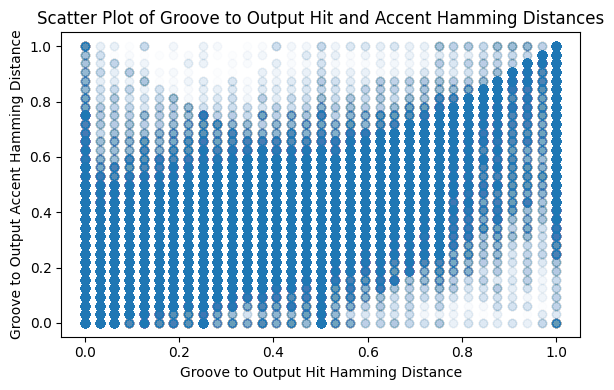

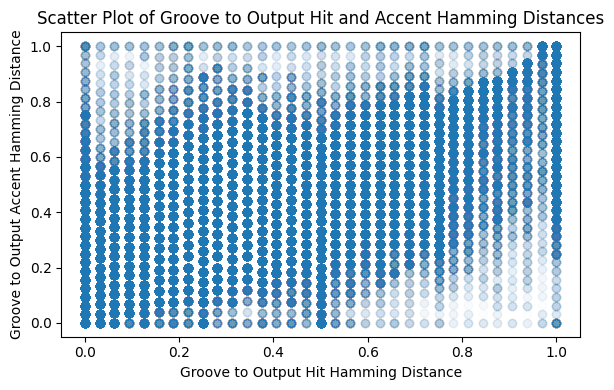

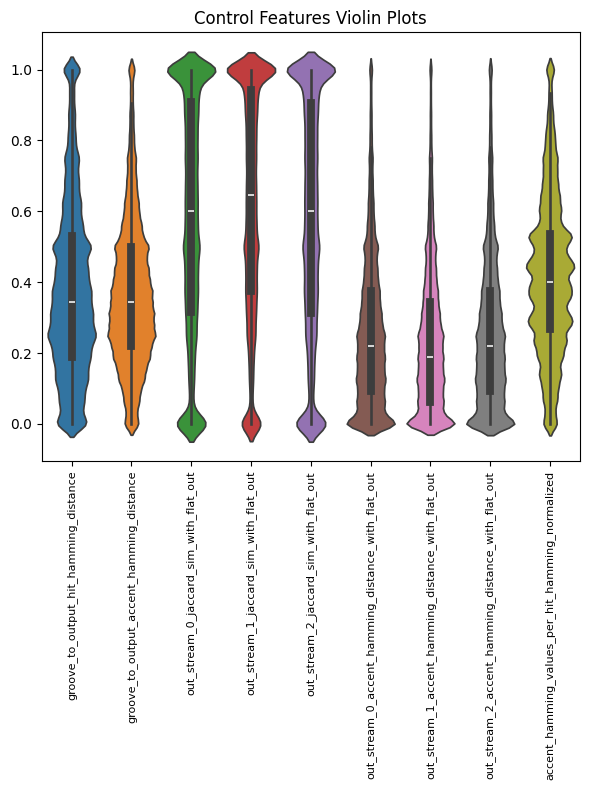

In [100]:
plot_scatter_input_output_distribution(control_features_df, use_normalized_accents=False)
plot_scatter_input_output_distribution(control_features_df, use_normalized_accents=True)
plot_control_features_violin(control_features_df)

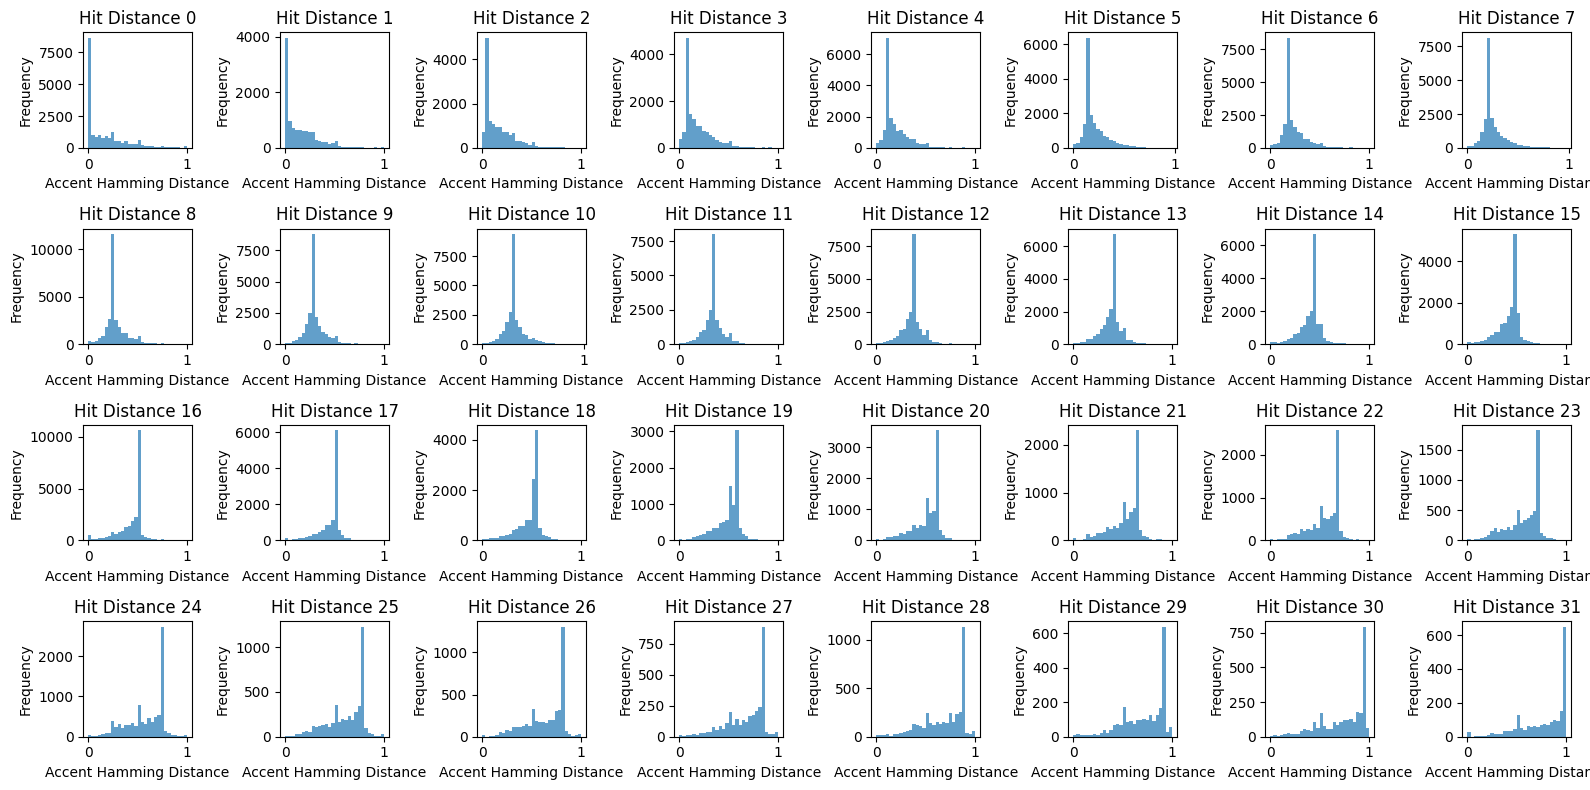

In [101]:
plot_histogram_accent_hamming_distance_grid(control_features_df, hit_hamming_distance_index=32)

mix of filtered lmd w/ 8 hvos

In [119]:
# LOAD DATASETS

data_dir = "data/triple_streams/split_2bars/mix_new" # "data/triple_streams/split_2bars/lmd"

# find all .pkl.bz2 files in the directory
dataset_pkls = [f for f in os.listdir(data_dir) if f.endswith('.pkl.bz2')]

# print the structure of each dataset
print_all_datasets_structure(dataset_pkls)

# load all loops from all datasets
split_n_bar_phrases = get_split_n_bar_phrases(dataset_pkls)

# print the number of phrases loaded
print(f"Number of split_n_bar_phrases loaded: {len(split_n_bar_phrases)}")

Dataset Structure for Dataset: lmd_batch_12_filtered.pkl.bz2
----------------------------------------
First Level Keys:
{'AllAvailableStreams'}
----------------------------------------
Second Level Keys:
['add8f179f2eed9954bf5c650c4421468', '9e025518d5451090b00287a46de5336a', '853a0af1b27e7f6b0bc4a6d8f3dcc352', 'fb6e76f77b6b8778c6eab0421ff9b935', '12eb26f849b8f76d5f86327728582cd8', '16c6bd97b3fe144038ad39aff127429e', 'd802538179799a683ccf5c80820e18ad', '904017ae5e1ceb7ab2c17022c8db49d9', 'a805f32479ffcfb888968b1bff8c0464', 'c738baa05055597b7da9cd9a1bb35ded']
----------------------------------------
Third Level Keys:
{'split_n_bar_phrases', 'filenames', 'hvo_sequences', 'compiled_single_hvos'}
----------------------------------------


Dataset Structure for Dataset: lmd_batch_06_filtered.pkl.bz2
----------------------------------------
First Level Keys:
{'AllAvailableStreams'}
----------------------------------------
Second Level Keys:
['6c8dbc49296190695efdcfff7ec53efd', '7f0f88a7f5f56

In [125]:
# Extract control features for all samples
control_features = {
    "sample_id": [],
    "collection": [],
}
# control_features_static_groove = {
#     "sample_id": [],
#     "collection": [],
# }
import tqdm

for hvo_sample in tqdm.tqdm(split_n_bar_phrases):
    for groove_dim in range(4): #<--- change to 1 if you don't want to use all streams as a groove (TODO: Change and generate different plots)
        control_features["sample_id"].append(hvo_sample.metadata['sample_id'])
        control_features["collection"].append(hvo_sample.metadata['collection'])

        features = extract_features_from_sets(hvo_sample, groove_dim)
        for key, value in features.items():
            if key not in control_features:
                control_features[key] = []
            control_features[key].append(value)

### Same as above, but remove the range(4) -> keeps groove static
### using this for comparisons
# for hvo_sample in tqdm.tqdm(split_n_bar_phrases):
#     for groove_dim in range(1): #<--- change to 1 if you don't want to use all streams as a groove (TODO: Change and generate different plots)
#         control_features_static_groove["sample_id"].append(hvo_sample.metadata['sample_id'])
#         control_features_static_groove["collection"].append(hvo_sample.metadata['collection'])

#         features = extract_features_from_sets(hvo_sample, groove_dim)
#         for key, value in features.items():
#             if key not in control_features_static_groove:
#                 control_features_static_groove[key] = []
#             control_features_static_groove[key].append(value)


# Convert to DataFrame
import pandas as pd
control_features_df = pd.DataFrame(control_features)
control_features_df


# control_features_static_groove_df = pd.DataFrame(control_features_static_groove)
# control_features_static_groove_df

  1%|          | 1253/201864 [00:01<02:57, 1128.04it/s]/var/folders/1b/mwwqz1l90n9_6fdy5008r1wr0000gn/T/ipykernel_85012/889556.py:56: RuntimeWarning:

invalid value encountered in scalar divide

100%|██████████| 201864/201864 [03:03<00:00, 1100.96it/s]


,sample_id,collection,groove_to_output_hit_hamming_distance,groove_to_output_accent_hamming_distance,out_stream_0_jaccard_sim_with_flat_out,out_stream_1_jaccard_sim_with_flat_out,out_stream_2_jaccard_sim_with_flat_out,out_stream_0_accent_hamming_distance_with_flat_out,out_stream_1_accent_hamming_distance_with_flat_out,out_stream_2_accent_hamming_distance_with_flat_out
0,922558b302d2b66273ad996e277c756a,lmd_batch_12_filtered,0.21875,0.12500,0.000000,1.000000,0.428571,0.03125,0.03125,0.00000
1,922558b302d2b66273ad996e277c756a,lmd_batch_12_filtered,0.43750,0.12500,0.500000,1.000000,0.428571,0.03125,0.12500,0.09375
2,922558b302d2b66273ad996e277c756a,lmd_batch_12_filtered,0.15625,0.12500,0.777778,0.000000,0.666667,0.03125,0.12500,0.09375
3,922558b302d2b66273ad996e277c756a,lmd_batch_12_filtered,0.25000,0.12500,0.500000,0.000000,1.000000,0.00000,0.09375,0.09375
4,922558b302d2b66273ad996e277c756a,lmd_batch_12_filtered,0.62500,0.18750,0.052632,0.947368,0.473684,0.15625,0.03125,0.18750
...,...,...,...,...,...,...,...,...,...,...
807451,2a0420c40862ea885271c77e63867d44,lmd_batch_01_filtered,0.53125,0.37500,0.500000,1.000000,0.000000,0.03125,0.21875,0.28125
807452,2a0420c40862ea885271c77e63867d44,lmd_batch_01_filtered,0.90625,0.50000,0.206897,0.551724,0.758621,0.31250,0.40625,0.18750
807453,2a0420c40862ea885271c77e63867d44,lmd_batch_01_filtered,0.71875,0.46875,0.000000,0.551724,0.758621,0.34375,0.25000,0.03125
807454,2a0420c40862ea885271c77e63867d44,lmd_batch_01_filtered,0.50000,0.43750,0.000000,0.230769,0.846154,0.46875,0.28125,0.15625


In [126]:
import numpy as np
# box plot import

# get unique hit hamming distances
hit_hamming_values = sorted(set(control_features_df["groove_to_output_hit_hamming_distance"].values))
print(hit_hamming_values)
accent_hamming_values_per_hit_hamming = {float(hit_hamming_value): [] for hit_hamming_value in hit_hamming_values}
for key in accent_hamming_values_per_hit_hamming.keys():
    accent_hamming_values_per_hit_hamming[key] = control_features_df[control_features_df["groove_to_output_hit_hamming_distance"] == key].groove_to_output_accent_hamming_distance.values
    # get box plot stats
    lower_bound = np.sort(accent_hamming_values_per_hit_hamming[key])[10]
    upper_bound = np.sort(accent_hamming_values_per_hit_hamming[key])[-30]
    print(key, lower_bound, upper_bound)

    if "accent_hamming_values_per_hit_hamming_normalized" not in control_features_df.columns:
        control_features_df["accent_hamming_values_per_hit_hamming_normalized"] = np.nan

    # stretch so that lower bound is 0 and upper bound is 1, then clip to 0-1 range
    if lower_bound < 0.1:
        lower_bound = 0.
    control_features_df.loc[control_features_df["groove_to_output_hit_hamming_distance"] == key, "accent_hamming_values_per_hit_hamming_normalized"] = \
        np.clip((control_features_df.loc[control_features_df["groove_to_output_hit_hamming_distance"] == key, "groove_to_output_accent_hamming_distance"] - lower_bound) / (upper_bound - lower_bound), 0, 1)

# print new normalized column, vs original
control_features_df[["groove_to_output_hit_hamming_distance", "groove_to_output_accent_hamming_distance", "accent_hamming_values_per_hit_hamming_normalized"]].head(10)


[np.float64(0.0), np.float64(0.03125), np.float64(0.0625), np.float64(0.09375), np.float64(0.125), np.float64(0.15625), np.float64(0.1875), np.float64(0.21875), np.float64(0.25), np.float64(0.28125), np.float64(0.3125), np.float64(0.34375), np.float64(0.375), np.float64(0.40625), np.float64(0.4375), np.float64(0.46875), np.float64(0.5), np.float64(0.53125), np.float64(0.5625), np.float64(0.59375), np.float64(0.625), np.float64(0.65625), np.float64(0.6875), np.float64(0.71875), np.float64(0.75), np.float64(0.78125), np.float64(0.8125), np.float64(0.84375), np.float64(0.875), np.float64(0.90625), np.float64(0.9375), np.float64(0.96875), np.float64(1.0)]
0.0 0.0 1.0
0.03125 0.0 0.9375
0.0625 0.0 0.9375
0.09375 0.0 0.90625
0.125 0.0 0.875
0.15625 0.0 0.8125
0.1875 0.0 0.875
0.21875 0.0 0.84375
0.25 0.0 0.9375
0.28125 0.0 0.84375
0.3125 0.0 0.875
0.34375 0.0 0.84375
0.375 0.0 0.84375
0.40625 0.0 0.90625
0.4375 0.0 0.9375
0.46875 0.0 0.96875
0.5 0.0 1.0
0.53125 0.0 0.875
0.5625 0.0 0.9375
0.

,groove_to_output_hit_hamming_distance,groove_to_output_accent_hamming_distance,accent_hamming_values_per_hit_hamming_normalized
0,0.21875,0.12500,0.148148
1,0.43750,0.12500,0.133333
2,0.15625,0.12500,0.153846
3,0.25000,0.12500,0.133333
4,0.62500,0.18750,0.193548
5,0.62500,0.18750,0.193548
6,0.34375,0.18750,0.222222
7,0.34375,0.18750,0.222222
8,0.56250,0.09375,0.100000
9,0.34375,0.09375,0.111111


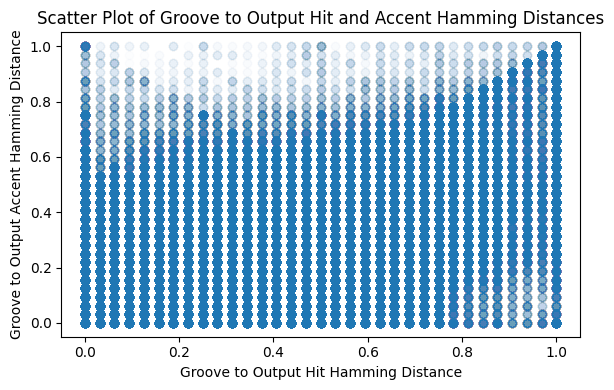

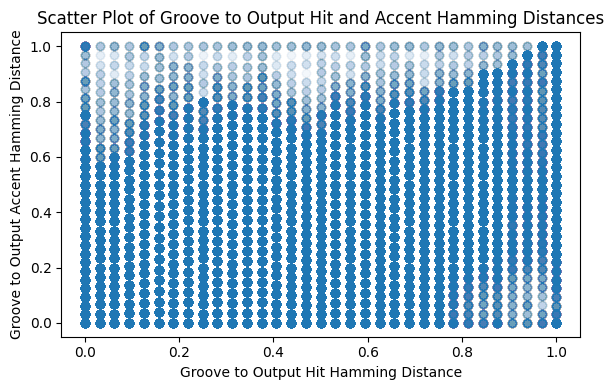

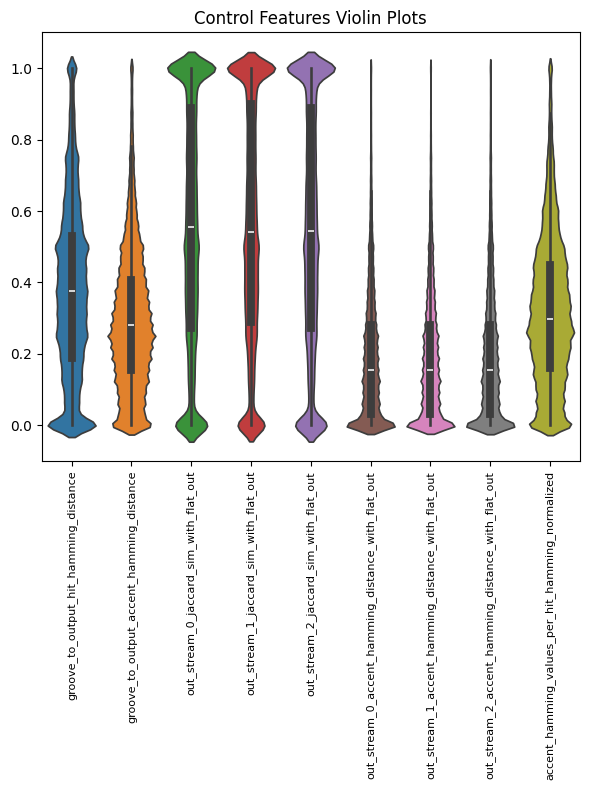

In [127]:
plot_scatter_input_output_distribution(control_features_df, use_normalized_accents=False)
plot_scatter_input_output_distribution(control_features_df, use_normalized_accents=True)
plot_control_features_violin(control_features_df)

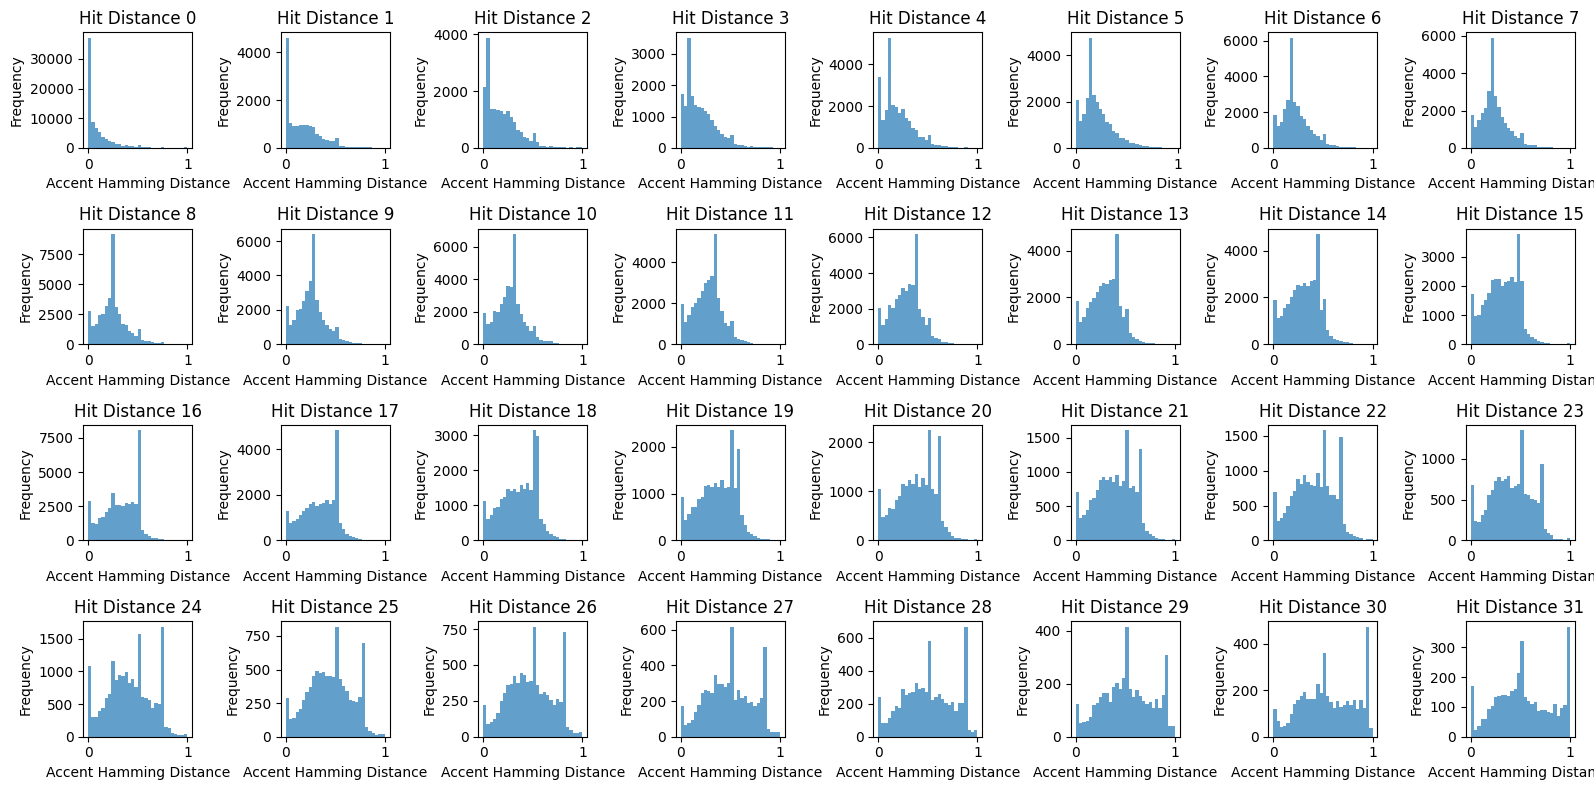

In [128]:
plot_histogram_accent_hamming_distance_grid(control_features_df, hit_hamming_distance_index=32)

In [129]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import numpy as np

def create_heatmap_histogram(df, key1, key2, bins=None, title=None, exclude_pairs=None,
                           show_zeros=False):
    """
    Creates an interactive heatmap histogram from a DataFrame using two keys.
    Shows frequency counts in each cell like a confusion matrix.

    Parameters:
    -----------
    df : pandas.DataFrame
        The input dataframe
    key1 : str
        Column name for x-axis
    key2 : str
        Column name for y-axis
    bins : int, tuple, or None, optional
        Number of bins for each dimension. If None (default), uses all unique values
    title : str, optional
        Plot title (default: auto-generated)
    exclude_pairs : list of tuples or tuple, optional
        Specific (key1, key2) value pairs to exclude from calculations
        e.g., [(10, 20), (15, 25)] or (10, 20) for single exclusion
    show_zeros : bool, optional
        Whether to show 0 counts in cells (default: False)

    Returns:
    --------
    plotly.graph_objects.Figure
        Interactive heatmap with counts
    """

    # Create a copy to avoid modifying original dataframe
    df_filtered = df.copy()

    # Handle exclusions
    if exclude_pairs is not None:
        # Convert single tuple to list of tuples
        if isinstance(exclude_pairs, tuple):
            exclude_pairs = [exclude_pairs]

        # Create boolean mask for rows to keep
        mask = pd.Series([True] * len(df_filtered), index=df_filtered.index)

        for pair in exclude_pairs:
            if len(pair) != 2:
                raise ValueError("Each exclusion pair must contain exactly 2 values")

            exclude_mask = (df_filtered[key1] == pair[0]) & (df_filtered[key2] == pair[1])
            mask = mask & ~exclude_mask

            # Print info about excluded points
            excluded_count = exclude_mask.sum()
            if excluded_count > 0:
                print(f"Excluded {excluded_count} points with ({key1}={pair[0]}, {key2}={pair[1]})")

        # Apply the mask
        df_filtered = df_filtered[mask]
        print(f"Total rows after exclusions: {len(df_filtered)} (original: {len(df)})")

    # Extract data for the two keys and remove NaN values
    valid_data = df_filtered[[key1, key2]].dropna()
    x_data = valid_data[key1]
    y_data = valid_data[key2]

    if len(x_data) == 0:
        print("Warning: No valid data points remaining after exclusions and NaN removal")
        return None

    # Handle bins=None case (use unique values)
    if bins is None:
        # Create cross-tabulation using unique values
        crosstab = pd.crosstab(y_data, x_data, dropna=False)

        # Get sorted unique values for consistent ordering
        x_values = sorted(x_data.unique())
        y_values = sorted(y_data.unique())

        # Reindex to ensure all values are present
        crosstab = crosstab.reindex(index=y_values, columns=x_values, fill_value=0)

        # Create labels (convert to string for display)
        x_labels = [str(x) for x in x_values]
        y_labels = [str(y) for y in y_values]

        # Get the count matrix
        count_matrix = crosstab.values

    else:
        # Use binning approach for numeric bins
        # Create 2D histogram using numpy
        hist, x_edges, y_edges = np.histogram2d(x_data, y_data, bins=bins)

        # Create bin labels for better readability
        x_labels = []
        for i in range(len(x_edges) - 1):
            x_labels.append(f"{x_edges[i]:.1f}-{x_edges[i+1]:.1f}")

        y_labels = []
        for i in range(len(y_edges) - 1):
            y_labels.append(f"{y_edges[i]:.1f}-{y_edges[i+1]:.1f}")

        # Transpose histogram for correct orientation
        count_matrix = hist.T

    # Create text annotations for each cell (showing the count)
    text_annotations = []
    for i in range(len(y_labels)):
        row = []
        for j in range(len(x_labels)):
            count = int(count_matrix[i, j])
            if count > 0 or show_zeros:
                row.append(str(count))
            else:
                row.append("")  # Don't show 0s for cleaner look unless requested
        text_annotations.append(row)

    # Create the heatmap
    fig = go.Figure(data=go.Heatmap(
        z=count_matrix,
        x=x_labels,
        y=y_labels,
        text=text_annotations,
        texttemplate="%{text}",
        textfont={"size": max(8, min(12, 300 // max(len(x_labels), len(y_labels))))},  # Dynamic font size
        colorscale='Plasma', # 'YlGnBu', 'Cividis', 'Plasma', 'Inferno', 'Magma'
        showscale=True,
        colorbar=dict(title="Count"),
        hovertemplate=f'{key1}: %{{x}}<br>{key2}: %{{y}}<br>Count: %{{z}}<extra></extra>'
    ))

    # Update layout
    if title is None:
        exclusion_info = f" (Excluded {len(exclude_pairs)} pairs)" if exclude_pairs else ""
        bins_info = "All unique values" if bins is None else f"{bins} bins"
        title = f'Heatmap: {key1} vs {key2} ({bins_info}){exclusion_info}'

    # Dynamic sizing based on number of categories
    plot_width = max(600, len(x_labels) * 40)
    plot_height = max(400, len(y_labels) * 30)

    fig.update_layout(
        title=title,
        xaxis_title=key1,
        yaxis_title=key2,
        width=min(plot_width, 1200),  # Cap maximum width
        height=min(plot_height, 800), # Cap maximum height
        xaxis=dict(tickangle=45 if len(x_labels) > 10 else 0),
        yaxis=dict(tickangle=0)
    )

    return fig

def create_binned_heatmap_histogram(df, key1, key2, bins=20, title=None, exclude_pairs=None,
                                  show_zeros=False):
    """
    Creates a heatmap for continuous data with explicit binning.
    This is the old behavior when you specifically want to bin continuous data.

    Parameters are the same as create_heatmap_histogram but bins defaults to 20.
    """
    return create_heatmap_histogram(df, key1, key2, bins=bins, title=title,
                                  exclude_pairs=exclude_pairs, show_zeros=show_zeros)

# Helper function to check data characteristics
def analyze_data_for_binning(df, key1, key2):
    """
    Analyzes the data to suggest whether binning might be needed.

    Returns:
    --------
    dict: Information about the data characteristics
    """
    x_data = df[key1].dropna()
    y_data = df[key2].dropna()

    x_unique_count = x_data.nunique()
    y_unique_count = y_data.nunique()

    x_is_numeric = pd.api.types.is_numeric_dtype(x_data)
    y_is_numeric = pd.api.types.is_numeric_dtype(y_data)

    analysis = {
        'x_unique_count': x_unique_count,
        'y_unique_count': y_unique_count,
        'x_is_numeric': x_is_numeric,
        'y_is_numeric': y_is_numeric,
        'total_combinations': x_unique_count * y_unique_count,
        'data_points': len(df[[key1, key2]].dropna())
    }

    # Suggestions
    if analysis['total_combinations'] > 100:
        analysis['suggestion'] = f"Consider using bins (e.g., bins=20) as you have {analysis['total_combinations']} unique combinations"
    elif analysis['total_combinations'] > 50:
        analysis['suggestion'] = "Data might benefit from binning for cleaner visualization"
    else:
        analysis['suggestion'] = "Using unique values (bins=None) should work well"

    return analysis

# Example usage:
"""
import pandas as pd
import numpy as np

# Example 1: Discrete/Categorical data (bins=None works great)
np.random.seed(42)
df_discrete = pd.DataFrame({
    'department': np.random.choice(['Sales', 'Engineering', 'Marketing', 'HR'], 500),
    'rating': np.random.choice([1, 2, 3, 4, 5], 500),
    'experience': np.random.choice(['Junior', 'Mid', 'Senior'], 500)
})

# This will use all unique values automatically
fig1 = create_heatmap_histogram(df_discrete, 'department', 'rating',
                               title='Department vs Rating (All Unique Values)')
fig1.show()

# Example 2: Continuous data with bins=None (might create many unique values)
df_continuous = pd.DataFrame({
    'height': np.random.normal(170, 10, 1000),
    'weight': np.random.normal(70, 15, 1000),
    'age': np.random.randint(18, 80, 1000)
})

# Check data characteristics first
analysis = analyze_data_for_binning(df_continuous, 'height', 'weight')
print("Data analysis:", analysis)

# This might create a very sparse heatmap due to many unique float values
fig2 = create_heatmap_histogram(df_continuous, 'height', 'weight',
                               title='Height vs Weight (All Unique Values - Might be Sparse)')

# Better approach for continuous data - use binning
fig3 = create_heatmap_histogram(df_continuous, 'height', 'weight', bins=15,
                               title='Height vs Weight (15x15 bins)')
fig3.show()

# Example 3: Integer data works well with bins=None
df_integers = pd.DataFrame({
    'score1': np.random.randint(0, 11, 1000),  # 0-10 score
    'score2': np.random.randint(0, 11, 1000),  # 0-10 score
    'category': np.random.choice(['A', 'B', 'C'], 1000)
})

fig4 = create_heatmap_histogram(df_integers, 'score1', 'score2',
                               title='Score1 vs Score2 (Integer Values)')
fig4.show()

# Example 4: With exclusions
fig5 = create_heatmap_histogram(df_discrete, 'department', 'rating',
                               exclude_pairs=[('Sales', 5), ('HR', 1)],
                               show_zeros=True,
                               title='Department vs Rating (With Exclusions)')
fig5.show()
"""

create_heatmap_histogram(control_features_df,
                         key1="groove_to_output_hit_hamming_distance",
                         key2="groove_to_output_accent_hamming_distance",
                         bins=None,
                         title="Heatmap Histogram of Groove to Output Hit Hamming Distance vs Accent Hamming Distance",
                         )




Old Stuff Below this - I need these pics......

In [7]:
# INSPECT SOME HVO SAMPLES
create_multitab_from_figures(split_n_bar_phrases[2000:2010], show_tabs=True)


Loading BokehJS ...

Tabs(id='p2301', ...)

In [ ]:

def plot_scatter_input_output_distribution_for_dataset(control_features_df, dataset, use_normalized_accents=False):
    #plt.figure(figsize=(6, 4))
    filtered_df = control_features_df[control_features_df['collection'] == dataset]
    x = filtered_df["groove_to_output_hit_hamming_distance"]
    y = filtered_df["groove_to_output_accent_hamming_distance"] if not use_normalized_accents else filtered_df["accent_hamming_values_per_hit_hamming_normalized"]
    plt.scatter(x, y, alpha=0.1)
    plt.xlabel("Groove to Output Hit Hamming Distance")
    plt.ylabel("Groove to Output Accent Hamming Distance")
    plt.title("Scatter Plot of Groove to Output Hit and Accent Hamming Distances for Dataset: " + dataset)
    plt.tight_layout()
    plt.show()


In [10]:
hvo_samples, sample_indices = get_randome_phrases(split_n_bar_phrases, n=1)
create_multitab_from_figures(hvo_samples, [f"ix: {ix}" for ix in sample_indices], show_tabs=True)
extract_features_from_sets(hvo_samples[0], groove_dim=0)

Loading BokehJS ...

{'groove_to_output_hit_hamming_distance': 0.375,
 'groove_to_output_accent_hamming_distance': 0.0,
 'out_stream_0_jaccard_sim_with_flat_out': 1.0,
 'out_stream_1_jaccard_sim_with_flat_out': 0.125,
 'out_stream_2_jaccard_sim_with_flat_out': 0.0625,
 'out_stream_0_accent_hamming_distance_with_flat_out': 0.0,
 'out_stream_1_accent_hamming_distance_with_flat_out': 0.0,
 'out_stream_2_accent_hamming_distance_with_flat_out': 0.0}

In [11]:
# Extract control features for all samples
control_features = {
    "sample_id": [],
    "collection": [],
}
# control_features_static_groove = {
#     "sample_id": [],
#     "collection": [],
# }
import tqdm

for hvo_sample in tqdm.tqdm(split_n_bar_phrases):
    for groove_dim in range(4): #<--- change to 1 if you don't want to use all streams as a groove (TODO: Change and generate different plots)
        control_features["sample_id"].append(hvo_sample.metadata['sample_id'])
        control_features["collection"].append(hvo_sample.metadata['collection'])

        features = extract_features_from_sets(hvo_sample, groove_dim)
        for key, value in features.items():
            if key not in control_features:
                control_features[key] = []
            control_features[key].append(value)

### Same as above, but remove the range(4) -> keeps groove static
### using this for comparisons
# for hvo_sample in tqdm.tqdm(split_n_bar_phrases):
#     for groove_dim in range(1): #<--- change to 1 if you don't want to use all streams as a groove (TODO: Change and generate different plots)
#         control_features_static_groove["sample_id"].append(hvo_sample.metadata['sample_id'])
#         control_features_static_groove["collection"].append(hvo_sample.metadata['collection'])

#         features = extract_features_from_sets(hvo_sample, groove_dim)
#         for key, value in features.items():
#             if key not in control_features_static_groove:
#                 control_features_static_groove[key] = []
#             control_features_static_groove[key].append(value)


# Convert to DataFrame
import pandas as pd
control_features_df = pd.DataFrame(control_features)
control_features_df


# control_features_static_groove_df = pd.DataFrame(control_features_static_groove)
# control_features_static_groove_df

  0%|          | 0/3543410 [00:00<?, ?it/s]/var/folders/1b/mwwqz1l90n9_6fdy5008r1wr0000gn/T/ipykernel_85012/742412560.py:56: RuntimeWarning: invalid value encountered in scalar divide
  return (intersection / union)
100%|██████████| 3543410/3543410 [50:30<00:00, 1169.29it/s] 


,sample_id,collection,groove_to_output_hit_hamming_distance,groove_to_output_accent_hamming_distance,out_stream_0_jaccard_sim_with_flat_out,out_stream_1_jaccard_sim_with_flat_out,out_stream_2_jaccard_sim_with_flat_out,out_stream_0_accent_hamming_distance_with_flat_out,out_stream_1_accent_hamming_distance_with_flat_out,out_stream_2_accent_hamming_distance_with_flat_out
0,f3c22467b980289fd3f2720859ba98d3,lmd_batch_07,0.12500,0.00000,0.000000,0.000000,1.000000,0.00000,0.00000,0.00000
1,f3c22467b980289fd3f2720859ba98d3,lmd_batch_07,0.12500,0.00000,0.000000,0.000000,1.000000,0.00000,0.00000,0.00000
2,f3c22467b980289fd3f2720859ba98d3,lmd_batch_07,0.12500,0.00000,0.000000,0.000000,1.000000,0.00000,0.00000,0.00000
3,f3c22467b980289fd3f2720859ba98d3,lmd_batch_07,0.12500,0.00000,NaN,NaN,NaN,0.00000,0.00000,0.00000
4,f3c22467b980289fd3f2720859ba98d3,lmd_batch_07,0.25000,0.00000,0.000000,0.000000,1.000000,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...
14173635,63fa3e76e1b6a97b2608ed22166aaec1,lmd_batch_02,0.28125,0.25000,0.937500,0.375000,0.437500,0.00000,0.43750,0.25000
14173636,63fa3e76e1b6a97b2608ed22166aaec1,lmd_batch_02,0.31250,0.31250,0.454545,0.272727,0.818182,0.25000,0.18750,0.00000
14173637,63fa3e76e1b6a97b2608ed22166aaec1,lmd_batch_02,0.37500,0.43750,0.733333,0.200000,0.600000,0.12500,0.37500,0.18750
14173638,63fa3e76e1b6a97b2608ed22166aaec1,lmd_batch_02,0.40625,0.37500,0.687500,0.312500,0.562500,0.12500,0.43750,0.18750


In [12]:
import numpy as np
# box plot import

# get unique hit hamming distances
hit_hamming_values = sorted(set(control_features_df["groove_to_output_hit_hamming_distance"].values))
print(hit_hamming_values)
accent_hamming_values_per_hit_hamming = {float(hit_hamming_value): [] for hit_hamming_value in hit_hamming_values}
for key in accent_hamming_values_per_hit_hamming.keys():
    accent_hamming_values_per_hit_hamming[key] = control_features_df[control_features_df["groove_to_output_hit_hamming_distance"] == key].groove_to_output_accent_hamming_distance.values
    # get box plot stats
    lower_bound = np.sort(accent_hamming_values_per_hit_hamming[key])[10]
    upper_bound = np.sort(accent_hamming_values_per_hit_hamming[key])[-30]
    print(key, lower_bound, upper_bound)

    if "accent_hamming_values_per_hit_hamming_normalized" not in control_features_df.columns:
        control_features_df["accent_hamming_values_per_hit_hamming_normalized"] = np.nan

    # stretch so that lower bound is 0 and upper bound is 1, then clip to 0-1 range
    if lower_bound < 0.1:
        lower_bound = 0.
    control_features_df.loc[control_features_df["groove_to_output_hit_hamming_distance"] == key, "accent_hamming_values_per_hit_hamming_normalized"] = \
        np.clip((control_features_df.loc[control_features_df["groove_to_output_hit_hamming_distance"] == key, "groove_to_output_accent_hamming_distance"] - lower_bound) / (upper_bound - lower_bound), 0, 1)

# print new normalized column, vs original
control_features_df[["groove_to_output_hit_hamming_distance", "groove_to_output_accent_hamming_distance", "accent_hamming_values_per_hit_hamming_normalized"]].head(10)


[np.float64(0.0), np.float64(0.03125), np.float64(0.0625), np.float64(0.09375), np.float64(0.125), np.float64(0.15625), np.float64(0.1875), np.float64(0.21875), np.float64(0.25), np.float64(0.28125), np.float64(0.3125), np.float64(0.34375), np.float64(0.375), np.float64(0.40625), np.float64(0.4375), np.float64(0.46875), np.float64(0.5), np.float64(0.53125), np.float64(0.5625), np.float64(0.59375), np.float64(0.625), np.float64(0.65625), np.float64(0.6875), np.float64(0.71875), np.float64(0.75), np.float64(0.78125), np.float64(0.8125), np.float64(0.84375), np.float64(0.875), np.float64(0.90625), np.float64(0.9375), np.float64(0.96875), np.float64(1.0)]
0.0 0.0 1.0
0.03125 0.0 0.96875
0.0625 0.0 1.0
0.09375 0.0 0.96875
0.125 0.0 1.0
0.15625 0.0 1.0
0.1875 0.0 1.0
0.21875 0.0 1.0
0.25 0.0 1.0
0.28125 0.0 0.96875
0.3125 0.0 1.0
0.34375 0.0 0.96875
0.375 0.0 1.0
0.40625 0.0 1.0
0.4375 0.0 1.0
0.46875 0.0 1.0
0.5 0.0 1.0
0.53125 0.0 1.0
0.5625 0.0 1.0
0.59375 0.0 1.0
0.625 0.0 1.0
0.65625 0.

,groove_to_output_hit_hamming_distance,groove_to_output_accent_hamming_distance,accent_hamming_values_per_hit_hamming_normalized
0,0.125,0.0,0.0
1,0.125,0.0,0.0
2,0.125,0.0,0.0
3,0.125,0.0,0.0
4,0.250,0.0,0.0
5,0.250,0.0,0.0
6,0.250,0.0,0.0
7,0.250,0.0,0.0
8,0.250,0.0,0.0
9,0.250,0.0,0.0


In [13]:
# import numpy as np
# # box plot import

# # get unique hit hamming distances
# hit_hamming_values = sorted(set(control_features_static_groove_df["groove_to_output_hit_hamming_distance"].values))
# print(hit_hamming_values)
# accent_hamming_values_per_hit_hamming = {float(hit_hamming_value): [] for hit_hamming_value in hit_hamming_values}
# for key in accent_hamming_values_per_hit_hamming.keys():
#     accent_hamming_values_per_hit_hamming[key] = control_features_static_groove_df[control_features_static_groove_df["groove_to_output_hit_hamming_distance"] == key].groove_to_output_accent_hamming_distance.values
#     # get box plot stats
#     lower_bound = np.sort(accent_hamming_values_per_hit_hamming[key])[10]
#     upper_bound = np.sort(accent_hamming_values_per_hit_hamming[key])[-30]
#     print(key, lower_bound, upper_bound)

#     if "accent_hamming_values_per_hit_hamming_normalized" not in control_features_static_groove_df.columns:
#         control_features_static_groove_df["accent_hamming_values_per_hit_hamming_normalized"] = np.nan

#     # strech so that lower bound is 0 and upper bound is 1, then clip to 0-1 range
#     if lower_bound < 0.1:
#         lower_bound = 0.
#     control_features_static_groove_df.loc[control_features_static_groove_df["groove_to_output_hit_hamming_distance"] == key, "accent_hamming_values_per_hit_hamming_normalized"] = \
#         np.clip((control_features_static_groove_df.loc[control_features_static_groove_df["groove_to_output_hit_hamming_distance"] == key, "groove_to_output_accent_hamming_distance"] - lower_bound) / (upper_bound - lower_bound), 0, 1)

# # print new normalized column, vs original
# control_features_static_groove_df[["groove_to_output_hit_hamming_distance", "groove_to_output_accent_hamming_distance", "accent_hamming_values_per_hit_hamming_normalized"]].head(10)


In [14]:
print(control_features_df['collection'].unique())

['lmd_batch_07' 'taptamdrum_hvo_output_both_is_and' 'lmd_batch_06'
 'taptamdrum_hvo_output_both_is_or' 'lmd_batch_04' 'lmd_batch_05'
 'candombe' 'lmd_batch_09' 'lmd_batch_10' 'lmd_batch_11' 'lmd_batch_01'
 'groove_midi' 'elbg' 'lmd_batch_08' 'lmd_batch_03' 'lmd_batch_12'
 'lmd_batch_02']


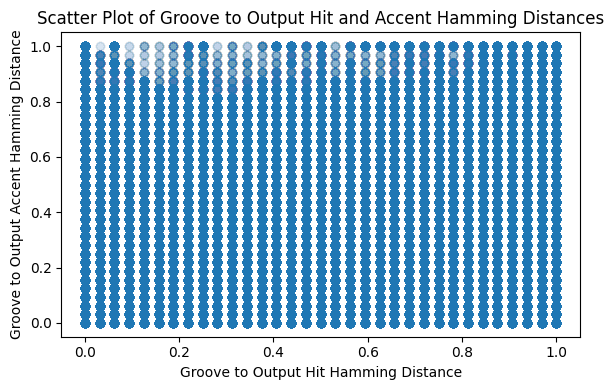

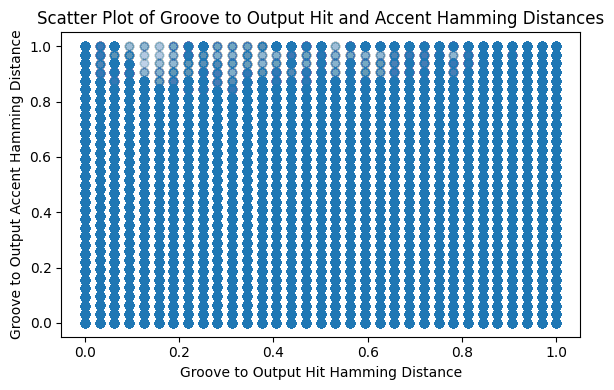

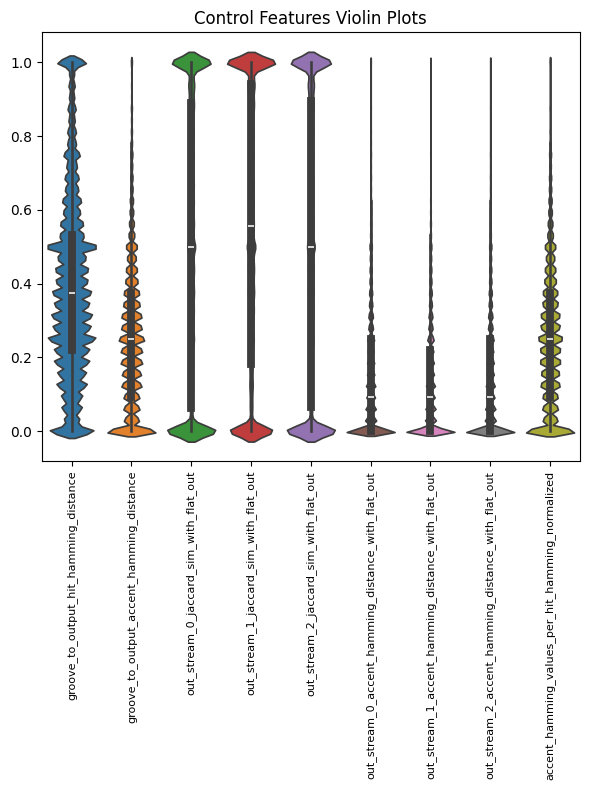

In [15]:
plot_scatter_input_output_distribution(control_features_df, use_normalized_accents=False)
plot_scatter_input_output_distribution(control_features_df, use_normalized_accents=True)
plot_control_features_violin(control_features_df)

In [16]:
# plot histogram of Accent hamming for hit distance of n (actual distance will be n*1./31.)
def plot_histogram_accent_hamming_distance(control_features_df, hit_hamming_distance_index=0):
    """
    Plot histogram of accent hamming distance for hit distance of n (actual distance will be n*1./32.)
    :param control_features_df: pd.DataFrame
        DataFrame containing the control features.
    :param hit_hamming_distance_index: int
        The index of the hit hamming distance to plot.
    """
    plt.figure(figsize=(6, 4))
    hit_hamming_distance = control_features_df["groove_to_output_hit_hamming_distance"]
    accent_hamming_distance = control_features_df["groove_to_output_accent_hamming_distance"]

    plt.hist(accent_hamming_distance[hit_hamming_distance == hit_hamming_distance_index/32.0], bins=30, alpha=0.7)
    plt.xlabel("Accent Hamming Distance")
    plt.ylabel("Frequency")
    plt.title(f"Histogram of Accent Hamming Distance for Hit Distance {hit_hamming_distance_index}")
    plt.tight_layout()
    plt.show()

# create a grid of 4 x 8 figures with the histogram of accent hamming distance for hit distance of n (actual distance will be n*1./32.)
def plot_histogram_accent_hamming_distance_grid(control_features_df, hit_hamming_distance_index=0):
    """
    Plot histogram of accent hamming distance for hit distance of n (actual distance will be n*1./32.)
    :param control_features_df: pd.DataFrame
        DataFrame containing the control features.
    :param hit_hamming_distance_index: int
        The index of the hit hamming distance to plot.
    """
    fig, axs = plt.subplots(4, 8, figsize=(16, 8))
    axs = axs.flatten()

    for i in range(32):
        hit_hamming_distance = control_features_df["groove_to_output_hit_hamming_distance"]
        accent_hamming_distance = control_features_df["groove_to_output_accent_hamming_distance"]

        axs[i].hist(accent_hamming_distance[hit_hamming_distance == i/32.0], bins=30, alpha=0.7)
        axs[i].set_xlabel("Accent Hamming Distance")
        axs[i].set_ylabel("Frequency")
        axs[i].set_title(f"Hit Distance {i}")

    plt.tight_layout()
    plt.show()

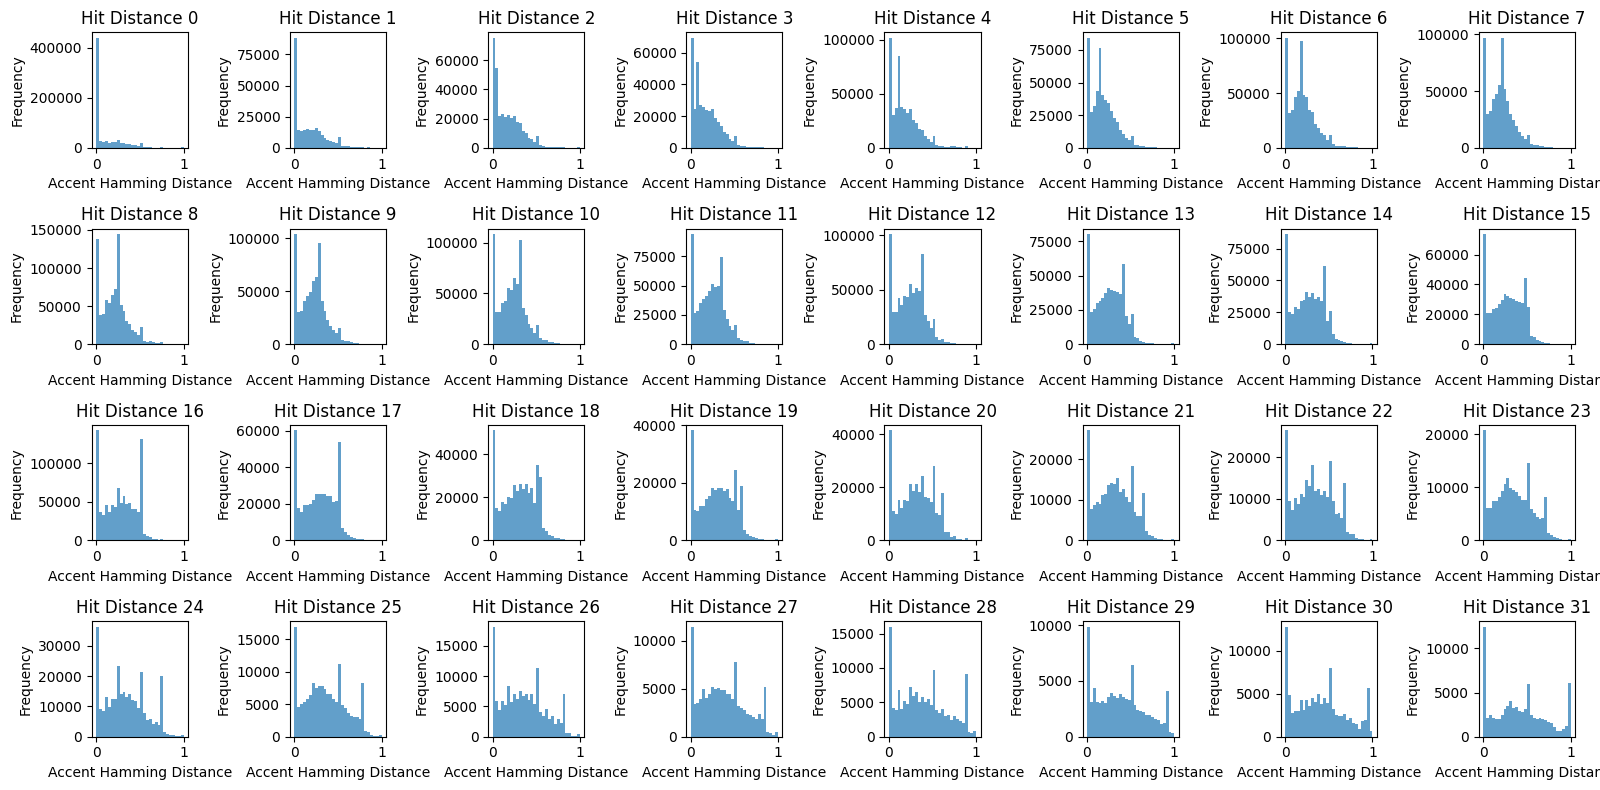

In [17]:
plot_histogram_accent_hamming_distance_grid(control_features_df, hit_hamming_distance_index=32)

In [18]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import numpy as np

def create_heatmap_histogram(df, key1, key2, bins=None, title=None, exclude_pairs=None,
                           show_zeros=False):
    """
    Creates an interactive heatmap histogram from a DataFrame using two keys.
    Shows frequency counts in each cell like a confusion matrix.

    Parameters:
    -----------
    df : pandas.DataFrame
        The input dataframe
    key1 : str
        Column name for x-axis
    key2 : str
        Column name for y-axis
    bins : int, tuple, or None, optional
        Number of bins for each dimension. If None (default), uses all unique values
    title : str, optional
        Plot title (default: auto-generated)
    exclude_pairs : list of tuples or tuple, optional
        Specific (key1, key2) value pairs to exclude from calculations
        e.g., [(10, 20), (15, 25)] or (10, 20) for single exclusion
    show_zeros : bool, optional
        Whether to show 0 counts in cells (default: False)

    Returns:
    --------
    plotly.graph_objects.Figure
        Interactive heatmap with counts
    """

    # Create a copy to avoid modifying original dataframe
    df_filtered = df.copy()

    # Handle exclusions
    if exclude_pairs is not None:
        # Convert single tuple to list of tuples
        if isinstance(exclude_pairs, tuple):
            exclude_pairs = [exclude_pairs]

        # Create boolean mask for rows to keep
        mask = pd.Series([True] * len(df_filtered), index=df_filtered.index)

        for pair in exclude_pairs:
            if len(pair) != 2:
                raise ValueError("Each exclusion pair must contain exactly 2 values")

            exclude_mask = (df_filtered[key1] == pair[0]) & (df_filtered[key2] == pair[1])
            mask = mask & ~exclude_mask

            # Print info about excluded points
            excluded_count = exclude_mask.sum()
            if excluded_count > 0:
                print(f"Excluded {excluded_count} points with ({key1}={pair[0]}, {key2}={pair[1]})")

        # Apply the mask
        df_filtered = df_filtered[mask]
        print(f"Total rows after exclusions: {len(df_filtered)} (original: {len(df)})")

    # Extract data for the two keys and remove NaN values
    valid_data = df_filtered[[key1, key2]].dropna()
    x_data = valid_data[key1]
    y_data = valid_data[key2]

    if len(x_data) == 0:
        print("Warning: No valid data points remaining after exclusions and NaN removal")
        return None

    # Handle bins=None case (use unique values)
    if bins is None:
        # Create cross-tabulation using unique values
        crosstab = pd.crosstab(y_data, x_data, dropna=False)

        # Get sorted unique values for consistent ordering
        x_values = sorted(x_data.unique())
        y_values = sorted(y_data.unique())

        # Reindex to ensure all values are present
        crosstab = crosstab.reindex(index=y_values, columns=x_values, fill_value=0)

        # Create labels (convert to string for display)
        x_labels = [str(x) for x in x_values]
        y_labels = [str(y) for y in y_values]

        # Get the count matrix
        count_matrix = crosstab.values

    else:
        # Use binning approach for numeric bins
        # Create 2D histogram using numpy
        hist, x_edges, y_edges = np.histogram2d(x_data, y_data, bins=bins)

        # Create bin labels for better readability
        x_labels = []
        for i in range(len(x_edges) - 1):
            x_labels.append(f"{x_edges[i]:.1f}-{x_edges[i+1]:.1f}")

        y_labels = []
        for i in range(len(y_edges) - 1):
            y_labels.append(f"{y_edges[i]:.1f}-{y_edges[i+1]:.1f}")

        # Transpose histogram for correct orientation
        count_matrix = hist.T

    # Create text annotations for each cell (showing the count)
    text_annotations = []
    for i in range(len(y_labels)):
        row = []
        for j in range(len(x_labels)):
            count = int(count_matrix[i, j])
            if count > 0 or show_zeros:
                row.append(str(count))
            else:
                row.append("")  # Don't show 0s for cleaner look unless requested
        text_annotations.append(row)

    # Create the heatmap
    fig = go.Figure(data=go.Heatmap(
        z=count_matrix,
        x=x_labels,
        y=y_labels,
        text=text_annotations,
        texttemplate="%{text}",
        textfont={"size": max(8, min(12, 300 // max(len(x_labels), len(y_labels))))},  # Dynamic font size
        colorscale='Plasma', # 'YlGnBu', 'Cividis', 'Plasma', 'Inferno', 'Magma'
        showscale=True,
        colorbar=dict(title="Count"),
        hovertemplate=f'{key1}: %{{x}}<br>{key2}: %{{y}}<br>Count: %{{z}}<extra></extra>'
    ))

    # Update layout
    if title is None:
        exclusion_info = f" (Excluded {len(exclude_pairs)} pairs)" if exclude_pairs else ""
        bins_info = "All unique values" if bins is None else f"{bins} bins"
        title = f'Heatmap: {key1} vs {key2} ({bins_info}){exclusion_info}'

    # Dynamic sizing based on number of categories
    plot_width = max(600, len(x_labels) * 40)
    plot_height = max(400, len(y_labels) * 30)

    fig.update_layout(
        title=title,
        xaxis_title=key1,
        yaxis_title=key2,
        width=min(plot_width, 1200),  # Cap maximum width
        height=min(plot_height, 800), # Cap maximum height
        xaxis=dict(tickangle=45 if len(x_labels) > 10 else 0),
        yaxis=dict(tickangle=0)
    )

    return fig

def create_binned_heatmap_histogram(df, key1, key2, bins=20, title=None, exclude_pairs=None,
                                  show_zeros=False):
    """
    Creates a heatmap for continuous data with explicit binning.
    This is the old behavior when you specifically want to bin continuous data.

    Parameters are the same as create_heatmap_histogram but bins defaults to 20.
    """
    return create_heatmap_histogram(df, key1, key2, bins=bins, title=title,
                                  exclude_pairs=exclude_pairs, show_zeros=show_zeros)

# Helper function to check data characteristics
def analyze_data_for_binning(df, key1, key2):
    """
    Analyzes the data to suggest whether binning might be needed.

    Returns:
    --------
    dict: Information about the data characteristics
    """
    x_data = df[key1].dropna()
    y_data = df[key2].dropna()

    x_unique_count = x_data.nunique()
    y_unique_count = y_data.nunique()

    x_is_numeric = pd.api.types.is_numeric_dtype(x_data)
    y_is_numeric = pd.api.types.is_numeric_dtype(y_data)

    analysis = {
        'x_unique_count': x_unique_count,
        'y_unique_count': y_unique_count,
        'x_is_numeric': x_is_numeric,
        'y_is_numeric': y_is_numeric,
        'total_combinations': x_unique_count * y_unique_count,
        'data_points': len(df[[key1, key2]].dropna())
    }

    # Suggestions
    if analysis['total_combinations'] > 100:
        analysis['suggestion'] = f"Consider using bins (e.g., bins=20) as you have {analysis['total_combinations']} unique combinations"
    elif analysis['total_combinations'] > 50:
        analysis['suggestion'] = "Data might benefit from binning for cleaner visualization"
    else:
        analysis['suggestion'] = "Using unique values (bins=None) should work well"

    return analysis

# Example usage:
"""
import pandas as pd
import numpy as np

# Example 1: Discrete/Categorical data (bins=None works great)
np.random.seed(42)
df_discrete = pd.DataFrame({
    'department': np.random.choice(['Sales', 'Engineering', 'Marketing', 'HR'], 500),
    'rating': np.random.choice([1, 2, 3, 4, 5], 500),
    'experience': np.random.choice(['Junior', 'Mid', 'Senior'], 500)
})

# This will use all unique values automatically
fig1 = create_heatmap_histogram(df_discrete, 'department', 'rating',
                               title='Department vs Rating (All Unique Values)')
fig1.show()

# Example 2: Continuous data with bins=None (might create many unique values)
df_continuous = pd.DataFrame({
    'height': np.random.normal(170, 10, 1000),
    'weight': np.random.normal(70, 15, 1000),
    'age': np.random.randint(18, 80, 1000)
})

# Check data characteristics first
analysis = analyze_data_for_binning(df_continuous, 'height', 'weight')
print("Data analysis:", analysis)

# This might create a very sparse heatmap due to many unique float values
fig2 = create_heatmap_histogram(df_continuous, 'height', 'weight',
                               title='Height vs Weight (All Unique Values - Might be Sparse)')

# Better approach for continuous data - use binning
fig3 = create_heatmap_histogram(df_continuous, 'height', 'weight', bins=15,
                               title='Height vs Weight (15x15 bins)')
fig3.show()

# Example 3: Integer data works well with bins=None
df_integers = pd.DataFrame({
    'score1': np.random.randint(0, 11, 1000),  # 0-10 score
    'score2': np.random.randint(0, 11, 1000),  # 0-10 score
    'category': np.random.choice(['A', 'B', 'C'], 1000)
})

fig4 = create_heatmap_histogram(df_integers, 'score1', 'score2',
                               title='Score1 vs Score2 (Integer Values)')
fig4.show()

# Example 4: With exclusions
fig5 = create_heatmap_histogram(df_discrete, 'department', 'rating',
                               exclude_pairs=[('Sales', 5), ('HR', 1)],
                               show_zeros=True,
                               title='Department vs Rating (With Exclusions)')
fig5.show()
"""

create_heatmap_histogram(control_features_df,
                         key1="groove_to_output_hit_hamming_distance",
                         key2="groove_to_output_accent_hamming_distance",
                         bins=None,
                         title="Heatmap Histogram of Groove to Output Hit Hamming Distance vs Accent Hamming Distance",
                         )




# Scatter plots of hit distance (hammming) and Accent distance (hamming) for each dataset

In [19]:
# plot_scatter_input_output_distribution_for_dataset(control_features_df, 'taptamdrum_hvo_output_both_is_and', use_normalized_accents=False)

# plot_scatter_input_output_distribution_for_dataset(control_features_df, 'taptamdrum_hvo_output_both_is_or', use_normalized_accents=False)
# #plot_scatter_input_output_distribution_for_dataset(control_features_df, 'taptamdrum_hvo_output_both_is_or', use_normalized_accents=True)

# plot_scatter_input_output_distribution_for_dataset(control_features_df, 'candombe', use_normalized_accents=False)
# #plot_scatter_input_output_distribution_for_dataset(control_features_df, 'candombe', use_normalized_accents=True)

# plot_scatter_input_output_distribution_for_dataset(control_features_df, 'groove_midi', use_normalized_accents=False)
# #plot_scatter_input_output_distribution_for_dataset(control_features_df, 'groove_midi', use_normalized_accents=True)

# plot_scatter_input_output_distribution_for_dataset(control_features_df, 'elbg', use_normalized_accents=False)
# #plot_scatter_input_output_distribution_for_dataset(control_features_df, 'elbg', use_normalized_accents=True)

In [20]:
# plot_scatter_input_output_distribution_for_dataset(control_features_df, 'taptamdrum_hvo_output_both_is_and', use_normalized_accents=True)

# plot_scatter_input_output_distribution_for_dataset(control_features_df, 'taptamdrum_hvo_output_both_is_or', use_normalized_accents=True)

# plot_scatter_input_output_distribution_for_dataset(control_features_df, 'candombe', use_normalized_accents=True)

# plot_scatter_input_output_distribution_for_dataset(control_features_df, 'groove_midi', use_normalized_accents=True)

# plot_scatter_input_output_distribution_for_dataset(control_features_df, 'elbg', use_normalized_accents=True)

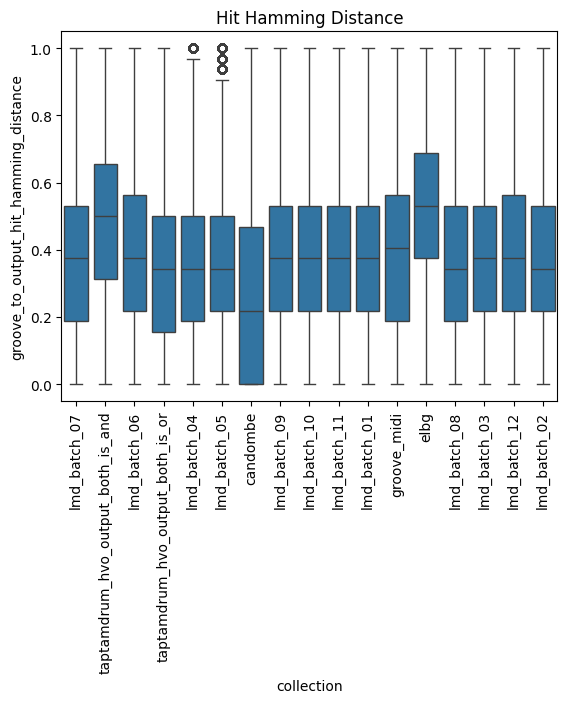

In [21]:
# Create boxplot
sns.boxplot(x='collection', y='groove_to_output_hit_hamming_distance', data=control_features_df)
plt.xticks(rotation=90)
plt.title('Hit Hamming Distance')
plt.show()

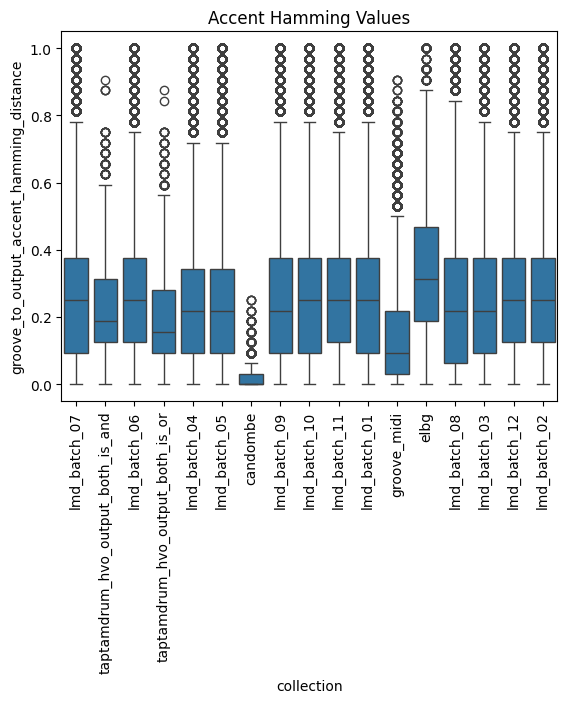

In [22]:
# Create boxplot
sns.boxplot(x='collection', y='groove_to_output_accent_hamming_distance', data=control_features_df)
plt.xticks(rotation=90)
plt.title('Accent Hamming Values')
plt.show()

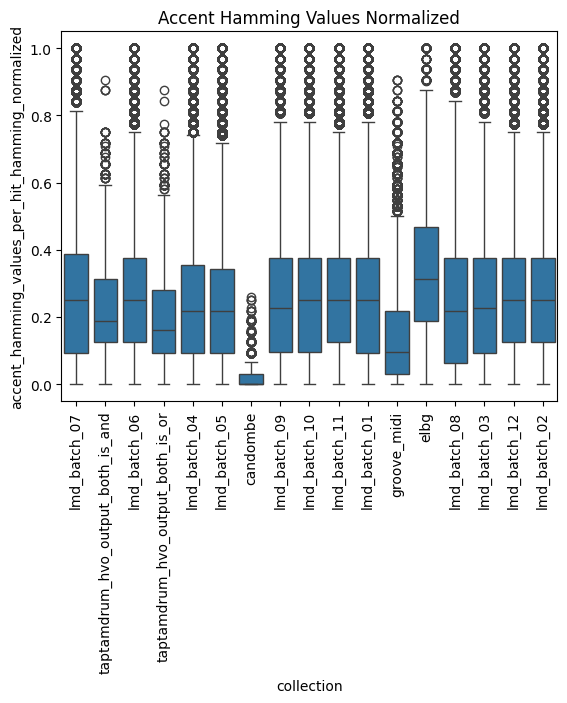

In [23]:
# Create boxplot
sns.boxplot(x='collection', y='accent_hamming_values_per_hit_hamming_normalized', data=control_features_df)
plt.xticks(rotation=90)
plt.title('Accent Hamming Values Normalized')
plt.show()

# NO LMD Data

In [44]:
# LOAD DATASETS

data_dir = "data/triple_streams/split_2bars/rest" # "data/triple_streams/split_2bars/lmd"

# find all .pkl.bz2 files in the directory
dataset_pkls = [f for f in os.listdir(data_dir) if f.endswith('.pkl.bz2')]

# print the structure of each dataset
print_all_datasets_structure(dataset_pkls)

# load all loops from all datasets
split_n_bar_phrases = get_split_n_bar_phrases(dataset_pkls)

# print the number of phrases loaded
print(f"Number of split_n_bar_phrases loaded: {len(split_n_bar_phrases)}")

Dataset Structure for Dataset: taptamdrum_hvo_output_both_is_and.pkl.bz2
----------------------------------------
First Level Keys:
{'AllAvailableStreams'}
----------------------------------------
Second Level Keys:
['4_p2_rep1', '269_p1_simple', '262_p1_simple', '149_p1_complex', '10_p1_rep2', '15_p1_rep2', '206_p1_simple', '7_p4_rep2', '34_p1_rep0', '11_p3_rep2']
----------------------------------------
Third Level Keys:
{'split_n_bar_phrases', 'filenames', 'hvo_sequences', 'compiled_single_hvos'}
----------------------------------------


Dataset Structure for Dataset: taptamdrum_hvo_output_both_is_or.pkl.bz2
----------------------------------------
First Level Keys:
{'AllAvailableStreams'}
----------------------------------------
Second Level Keys:
['4_p2_rep1', '269_p1_simple', '262_p1_simple', '149_p1_complex', '10_p1_rep2', '15_p1_rep2', '206_p1_simple', '7_p4_rep2', '34_p1_rep0', '11_p3_rep2']
----------------------------------------
Third Level Keys:
{'split_n_bar_phrases', 'f

In [45]:
# Extract control features for all samples
control_features = {
    "sample_id": [],
    "collection": [],
}
# control_features_static_groove = {
#     "sample_id": [],
#     "collection": [],
# }
import tqdm

for hvo_sample in tqdm.tqdm(split_n_bar_phrases):
    for groove_dim in range(4): #<--- change to 1 if you don't want to use all streams as a groove (TODO: Change and generate different plots)
        control_features["sample_id"].append(hvo_sample.metadata['sample_id'])
        control_features["collection"].append(hvo_sample.metadata['collection'])

        features = extract_features_from_sets(hvo_sample, groove_dim)
        for key, value in features.items():
            if key not in control_features:
                control_features[key] = []
            control_features[key].append(value)

### Same as above, but remove the range(4) -> keeps groove static
### using this for comparisons
# for hvo_sample in tqdm.tqdm(split_n_bar_phrases):
#     for groove_dim in range(1): #<--- change to 1 if you don't want to use all streams as a groove (TODO: Change and generate different plots)
#         control_features_static_groove["sample_id"].append(hvo_sample.metadata['sample_id'])
#         control_features_static_groove["collection"].append(hvo_sample.metadata['collection'])

#         features = extract_features_from_sets(hvo_sample, groove_dim)
#         for key, value in features.items():
#             if key not in control_features_static_groove:
#                 control_features_static_groove[key] = []
#             control_features_static_groove[key].append(value)


# Convert to DataFrame
import pandas as pd
control_features_df = pd.DataFrame(control_features)
control_features_df


# control_features_static_groove_df = pd.DataFrame(control_features_static_groove)
# control_features_static_groove_df

 51%|█████     | 44685/88224 [00:39<00:37, 1149.97it/s]/var/folders/1b/mwwqz1l90n9_6fdy5008r1wr0000gn/T/ipykernel_85012/742412560.py:56: RuntimeWarning:

invalid value encountered in scalar divide

100%|██████████| 88224/88224 [01:17<00:00, 1131.79it/s]


,sample_id,collection,groove_to_output_hit_hamming_distance,groove_to_output_accent_hamming_distance,out_stream_0_jaccard_sim_with_flat_out,out_stream_1_jaccard_sim_with_flat_out,out_stream_2_jaccard_sim_with_flat_out,out_stream_0_accent_hamming_distance_with_flat_out,out_stream_1_accent_hamming_distance_with_flat_out,out_stream_2_accent_hamming_distance_with_flat_out
0,203_p1_simple,taptamdrum_hvo_output_both_is_and,0.62500,0.12500,1.000000,0.166667,0.666667,0.00000,0.12500,0.25000
1,203_p1_simple,taptamdrum_hvo_output_both_is_and,0.25000,0.12500,0.250000,0.250000,1.000000,0.00000,0.00000,0.12500
2,203_p1_simple,taptamdrum_hvo_output_both_is_and,0.62500,0.12500,0.166667,1.000000,0.666667,0.12500,0.00000,0.25000
3,203_p1_simple,taptamdrum_hvo_output_both_is_and,0.25000,0.25000,0.166667,1.000000,0.166667,0.12500,0.00000,0.12500
4,345_p1_simple,taptamdrum_hvo_output_both_is_and,0.31250,0.34375,0.000000,0.333333,0.666667,0.15625,0.00000,0.15625
...,...,...,...,...,...,...,...,...,...,...
352891,8593_attempt0,elbg,0.43750,0.53125,1.000000,0.533333,0.333333,0.03125,0.46875,0.46875
352892,9204_attempt1,elbg,0.25000,0.00000,0.000000,0.000000,1.000000,0.00000,0.00000,0.00000
352893,9204_attempt1,elbg,0.46875,0.00000,0.466667,0.000000,1.000000,0.00000,0.00000,0.00000
352894,9204_attempt1,elbg,0.46875,0.00000,0.466667,0.000000,1.000000,0.00000,0.00000,0.00000


In [46]:
import numpy as np
# box plot import

# get unique hit hamming distances
hit_hamming_values = sorted(set(control_features_df["groove_to_output_hit_hamming_distance"].values))
print(hit_hamming_values)
accent_hamming_values_per_hit_hamming = {float(hit_hamming_value): [] for hit_hamming_value in hit_hamming_values}
for key in accent_hamming_values_per_hit_hamming.keys():
    accent_hamming_values_per_hit_hamming[key] = control_features_df[control_features_df["groove_to_output_hit_hamming_distance"] == key].groove_to_output_accent_hamming_distance.values
    # get box plot stats
    lower_bound = np.sort(accent_hamming_values_per_hit_hamming[key])[10]
    upper_bound = np.sort(accent_hamming_values_per_hit_hamming[key])[-30]
    print(key, lower_bound, upper_bound)

    if "accent_hamming_values_per_hit_hamming_normalized" not in control_features_df.columns:
        control_features_df["accent_hamming_values_per_hit_hamming_normalized"] = np.nan

    # stretch so that lower bound is 0 and upper bound is 1, then clip to 0-1 range
    if lower_bound < 0.1:
        lower_bound = 0.
    control_features_df.loc[control_features_df["groove_to_output_hit_hamming_distance"] == key, "accent_hamming_values_per_hit_hamming_normalized"] = \
        np.clip((control_features_df.loc[control_features_df["groove_to_output_hit_hamming_distance"] == key, "groove_to_output_accent_hamming_distance"] - lower_bound) / (upper_bound - lower_bound), 0, 1)

# print new normalized column, vs original
control_features_df[["groove_to_output_hit_hamming_distance", "groove_to_output_accent_hamming_distance", "accent_hamming_values_per_hit_hamming_normalized"]].head(10)

[np.float64(0.0), np.float64(0.03125), np.float64(0.0625), np.float64(0.09375), np.float64(0.125), np.float64(0.15625), np.float64(0.1875), np.float64(0.21875), np.float64(0.25), np.float64(0.28125), np.float64(0.3125), np.float64(0.34375), np.float64(0.375), np.float64(0.40625), np.float64(0.4375), np.float64(0.46875), np.float64(0.5), np.float64(0.53125), np.float64(0.5625), np.float64(0.59375), np.float64(0.625), np.float64(0.65625), np.float64(0.6875), np.float64(0.71875), np.float64(0.75), np.float64(0.78125), np.float64(0.8125), np.float64(0.84375), np.float64(0.875), np.float64(0.90625), np.float64(0.9375), np.float64(0.96875), np.float64(1.0)]
0.0 0.0 0.40625
0.03125 0.0 0.4375
0.0625 0.0 0.4375
0.09375 0.0 0.46875
0.125 0.0 0.5
0.15625 0.0 0.46875
0.1875 0.0 0.53125
0.21875 0.0 0.5625
0.25 0.0 0.59375
0.28125 0.0 0.5625
0.3125 0.0 0.65625
0.34375 0.0 0.625
0.375 0.0 0.625
0.40625 0.0 0.65625
0.4375 0.0 0.65625
0.46875 0.0 0.6875
0.5 0.0 0.6875
0.53125 0.0 0.6875
0.5625 0.0 0.7

,groove_to_output_hit_hamming_distance,groove_to_output_accent_hamming_distance,accent_hamming_values_per_hit_hamming_normalized
0,0.62500,0.12500,0.166667
1,0.25000,0.12500,0.210526
2,0.62500,0.12500,0.166667
3,0.25000,0.25000,0.421053
4,0.31250,0.34375,0.523810
5,0.84375,0.43750,0.583333
6,0.68750,0.34375,0.458333
7,0.46875,0.43750,0.636364
8,0.06250,0.28125,0.642857
9,0.50000,0.28125,0.409091


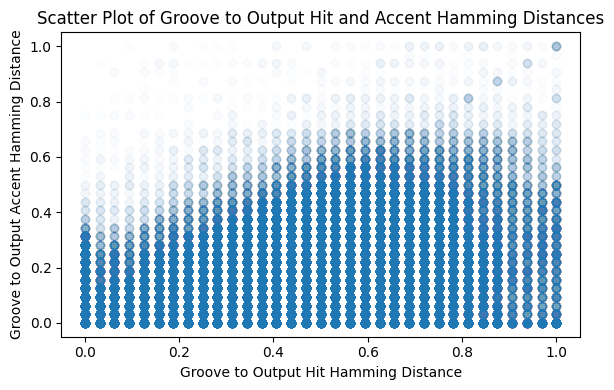

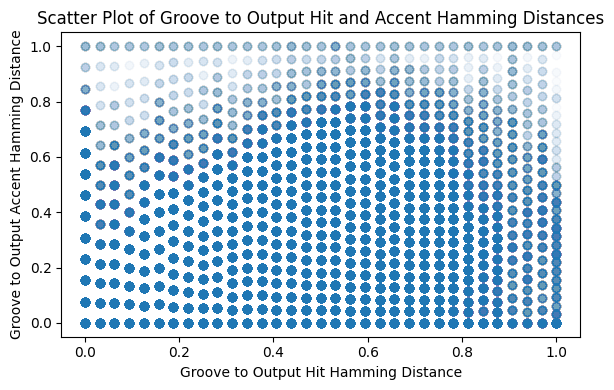

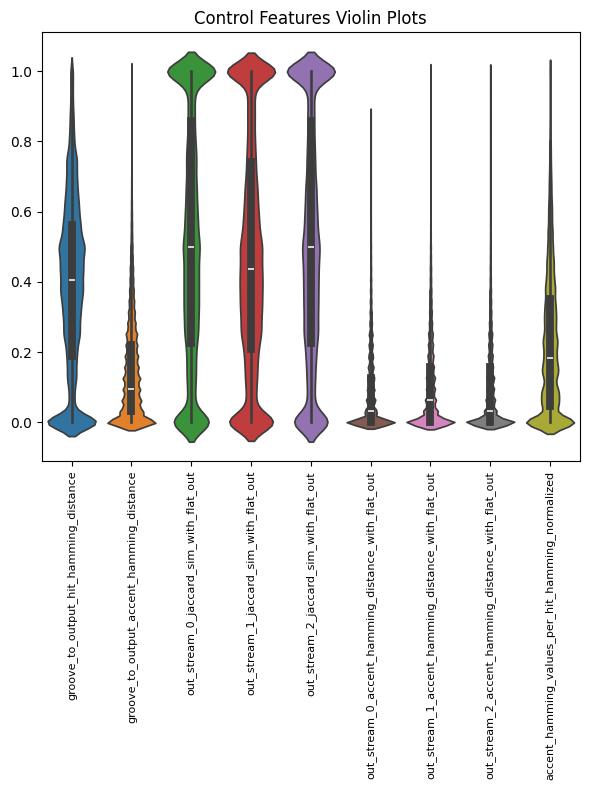

In [47]:
plot_scatter_input_output_distribution(control_features_df, use_normalized_accents=False)
plot_scatter_input_output_distribution(control_features_df, use_normalized_accents=True)
plot_control_features_violin(control_features_df)

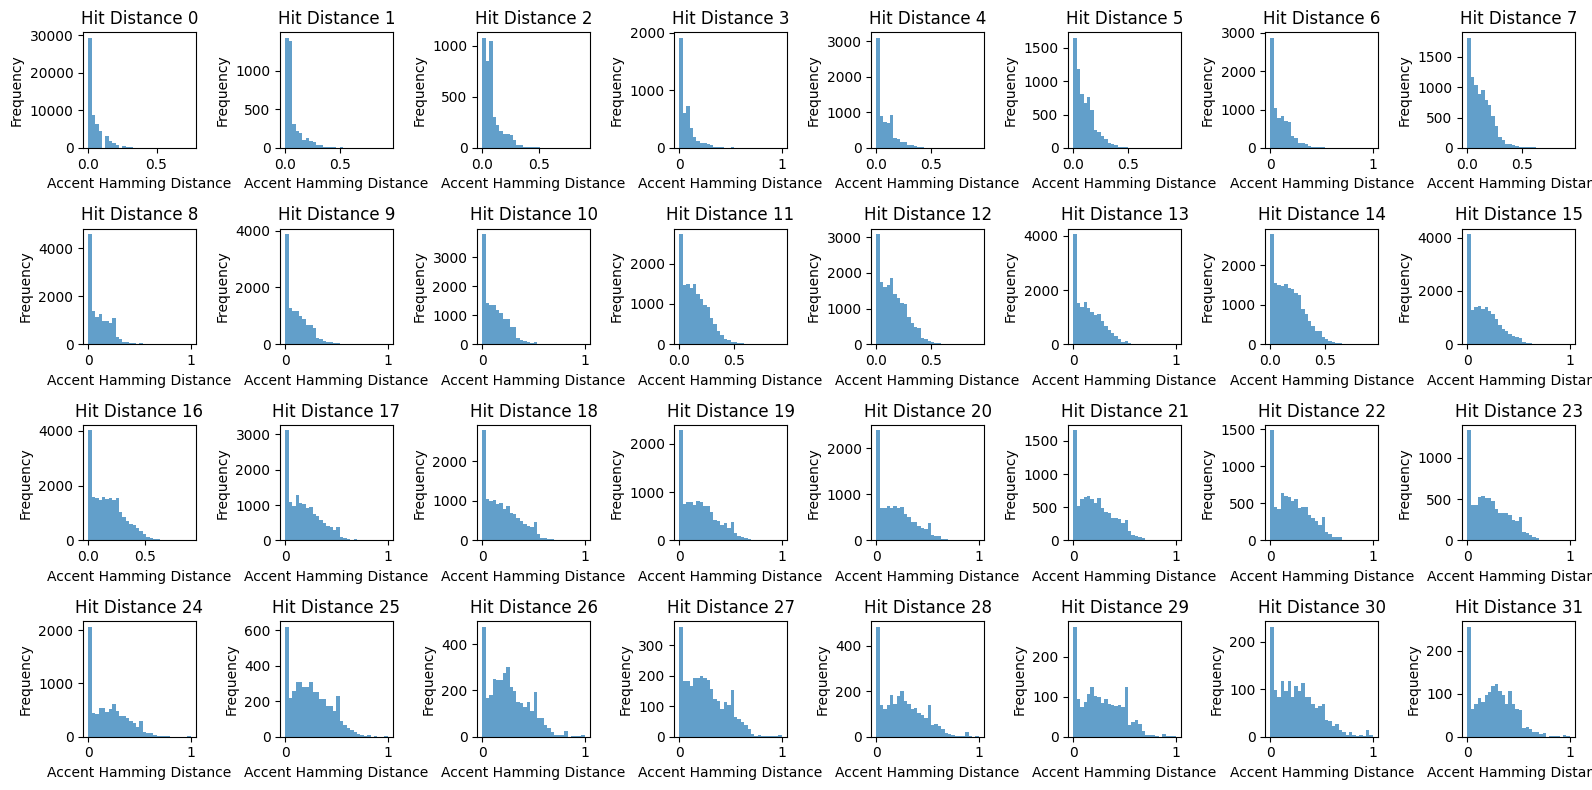

In [48]:
plot_histogram_accent_hamming_distance_grid(control_features_df, hit_hamming_distance_index=32)

In [49]:
create_heatmap_histogram(control_features_df,
                         key1="groove_to_output_hit_hamming_distance",
                         key2="groove_to_output_accent_hamming_distance",
                         bins=None,
                         title="Heatmap Histogram of Groove to Output Hit Hamming Distance vs Accent Hamming Distance",
                         )

# LMD Subset
## First 10 of 60

In [50]:
# LOAD DATASETS

data_dir = "data/triple_streams/split_2bars/lmd_subset" # "data/triple_streams/split_2bars/lmd"

# find all .pkl.bz2 files in the directory
dataset_pkls = [f for f in os.listdir(data_dir) if f.endswith('.pkl.bz2')]

# print the structure of each dataset
print_all_datasets_structure(dataset_pkls)

# load all loops from all datasets
split_n_bar_phrases = get_split_n_bar_phrases(dataset_pkls)

# print the number of phrases loaded
print(f"Number of split_n_bar_phrases loaded: {len(split_n_bar_phrases)}")

Dataset Structure for Dataset: lmd_batch_07.pkl.bz2
----------------------------------------
First Level Keys:
{'AllAvailableStreams'}
----------------------------------------
Second Level Keys:
['5da07472cbdc070d284ae4a6190fd5f4', 'ba048696cc56f509afc9fcb226582a4d', '26eaffd9a9ffcaac499a17a7d5181632', '8b5cad5f63f4de08290054394f435441', '4c4811c3c2950edfd6e3451e31704bd6', 'cfdce0d0f8aa13c61b9020c3b5df6df7', '8fae0bc961d3858d1a16b0caf30e634b', '8d1a414f39d9ffa9a4de7459d77b61a5', 'cef91441642319d85a0323595fbec067', '35f6ab2cd59d0e364a5be7b7eeb1df4f']
----------------------------------------
Third Level Keys:
{'split_n_bar_phrases', 'filenames', 'hvo_sequences', 'compiled_single_hvos'}
----------------------------------------


Dataset Structure for Dataset: lmd_batch_06.pkl.bz2
----------------------------------------
First Level Keys:
{'AllAvailableStreams'}
----------------------------------------
Second Level Keys:
['6c8dbc49296190695efdcfff7ec53efd', '7f0f88a7f5f56a8a3349b090889f27b

In [51]:
# Extract control features for all samples
control_features = {
    "sample_id": [],
    "collection": [],
}
# control_features_static_groove = {
#     "sample_id": [],
#     "collection": [],
# }
import tqdm

for hvo_sample in tqdm.tqdm(split_n_bar_phrases):
    for groove_dim in range(4): #<--- change to 1 if you don't want to use all streams as a groove (TODO: Change and generate different plots)
        control_features["sample_id"].append(hvo_sample.metadata['sample_id'])
        control_features["collection"].append(hvo_sample.metadata['collection'])

        features = extract_features_from_sets(hvo_sample, groove_dim)
        for key, value in features.items():
            if key not in control_features:
                control_features[key] = []
            control_features[key].append(value)

### Same as above, but remove the range(4) -> keeps groove static
### using this for comparisons
# for hvo_sample in tqdm.tqdm(split_n_bar_phrases):
#     for groove_dim in range(1): #<--- change to 1 if you don't want to use all streams as a groove (TODO: Change and generate different plots)
#         control_features_static_groove["sample_id"].append(hvo_sample.metadata['sample_id'])
#         control_features_static_groove["collection"].append(hvo_sample.metadata['collection'])

#         features = extract_features_from_sets(hvo_sample, groove_dim)
#         for key, value in features.items():
#             if key not in control_features_static_groove:
#                 control_features_static_groove[key] = []
#             control_features_static_groove[key].append(value)


# Convert to DataFrame
import pandas as pd
control_features_df = pd.DataFrame(control_features)
control_features_df


# control_features_static_groove_df = pd.DataFrame(control_features_static_groove)
# control_features_static_groove_df

  0%|          | 0/2904360 [00:00<?, ?it/s]/var/folders/1b/mwwqz1l90n9_6fdy5008r1wr0000gn/T/ipykernel_85012/742412560.py:56: RuntimeWarning:

invalid value encountered in scalar divide

100%|██████████| 2904360/2904360 [41:28<00:00, 1167.01it/s]


,sample_id,collection,groove_to_output_hit_hamming_distance,groove_to_output_accent_hamming_distance,out_stream_0_jaccard_sim_with_flat_out,out_stream_1_jaccard_sim_with_flat_out,out_stream_2_jaccard_sim_with_flat_out,out_stream_0_accent_hamming_distance_with_flat_out,out_stream_1_accent_hamming_distance_with_flat_out,out_stream_2_accent_hamming_distance_with_flat_out
0,f3c22467b980289fd3f2720859ba98d3,lmd_batch_07,0.12500,0.00000,0.000000,0.000000,1.000000,0.00000,0.00000,0.00000
1,f3c22467b980289fd3f2720859ba98d3,lmd_batch_07,0.12500,0.00000,0.000000,0.000000,1.000000,0.00000,0.00000,0.00000
2,f3c22467b980289fd3f2720859ba98d3,lmd_batch_07,0.12500,0.00000,0.000000,0.000000,1.000000,0.00000,0.00000,0.00000
3,f3c22467b980289fd3f2720859ba98d3,lmd_batch_07,0.12500,0.00000,NaN,NaN,NaN,0.00000,0.00000,0.00000
4,f3c22467b980289fd3f2720859ba98d3,lmd_batch_07,0.25000,0.00000,0.000000,0.000000,1.000000,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...
11617435,63fa3e76e1b6a97b2608ed22166aaec1,lmd_batch_02,0.28125,0.25000,0.937500,0.375000,0.437500,0.00000,0.43750,0.25000
11617436,63fa3e76e1b6a97b2608ed22166aaec1,lmd_batch_02,0.31250,0.31250,0.454545,0.272727,0.818182,0.25000,0.18750,0.00000
11617437,63fa3e76e1b6a97b2608ed22166aaec1,lmd_batch_02,0.37500,0.43750,0.733333,0.200000,0.600000,0.12500,0.37500,0.18750
11617438,63fa3e76e1b6a97b2608ed22166aaec1,lmd_batch_02,0.40625,0.37500,0.687500,0.312500,0.562500,0.12500,0.43750,0.18750


In [52]:
import numpy as np
# box plot import

# get unique hit hamming distances
hit_hamming_values = sorted(set(control_features_df["groove_to_output_hit_hamming_distance"].values))
print(hit_hamming_values)
accent_hamming_values_per_hit_hamming = {float(hit_hamming_value): [] for hit_hamming_value in hit_hamming_values}
for key in accent_hamming_values_per_hit_hamming.keys():
    accent_hamming_values_per_hit_hamming[key] = control_features_df[control_features_df["groove_to_output_hit_hamming_distance"] == key].groove_to_output_accent_hamming_distance.values
    # get box plot stats
    lower_bound = np.sort(accent_hamming_values_per_hit_hamming[key])[10]
    upper_bound = np.sort(accent_hamming_values_per_hit_hamming[key])[-30]
    print(key, lower_bound, upper_bound)

    if "accent_hamming_values_per_hit_hamming_normalized" not in control_features_df.columns:
        control_features_df["accent_hamming_values_per_hit_hamming_normalized"] = np.nan

    # stretch so that lower bound is 0 and upper bound is 1, then clip to 0-1 range
    if lower_bound < 0.1:
        lower_bound = 0.
    control_features_df.loc[control_features_df["groove_to_output_hit_hamming_distance"] == key, "accent_hamming_values_per_hit_hamming_normalized"] = \
        np.clip((control_features_df.loc[control_features_df["groove_to_output_hit_hamming_distance"] == key, "groove_to_output_accent_hamming_distance"] - lower_bound) / (upper_bound - lower_bound), 0, 1)

# print new normalized column, vs original
control_features_df[["groove_to_output_hit_hamming_distance", "groove_to_output_accent_hamming_distance", "accent_hamming_values_per_hit_hamming_normalized"]].head(10)

[np.float64(0.0), np.float64(0.03125), np.float64(0.0625), np.float64(0.09375), np.float64(0.125), np.float64(0.15625), np.float64(0.1875), np.float64(0.21875), np.float64(0.25), np.float64(0.28125), np.float64(0.3125), np.float64(0.34375), np.float64(0.375), np.float64(0.40625), np.float64(0.4375), np.float64(0.46875), np.float64(0.5), np.float64(0.53125), np.float64(0.5625), np.float64(0.59375), np.float64(0.625), np.float64(0.65625), np.float64(0.6875), np.float64(0.71875), np.float64(0.75), np.float64(0.78125), np.float64(0.8125), np.float64(0.84375), np.float64(0.875), np.float64(0.90625), np.float64(0.9375), np.float64(0.96875), np.float64(1.0)]
0.0 0.0 1.0
0.03125 0.0 0.96875
0.0625 0.0 1.0
0.09375 0.0 0.9375
0.125 0.0 1.0
0.15625 0.0 1.0
0.1875 0.0 1.0
0.21875 0.0 1.0
0.25 0.0 1.0
0.28125 0.0 0.96875
0.3125 0.0 1.0
0.34375 0.0 0.96875
0.375 0.0 1.0
0.40625 0.0 1.0
0.4375 0.0 1.0
0.46875 0.0 1.0
0.5 0.0 1.0
0.53125 0.0 1.0
0.5625 0.0 1.0
0.59375 0.0 1.0
0.625 0.0 1.0
0.65625 0.0

,groove_to_output_hit_hamming_distance,groove_to_output_accent_hamming_distance,accent_hamming_values_per_hit_hamming_normalized
0,0.125,0.0,0.0
1,0.125,0.0,0.0
2,0.125,0.0,0.0
3,0.125,0.0,0.0
4,0.250,0.0,0.0
5,0.250,0.0,0.0
6,0.250,0.0,0.0
7,0.250,0.0,0.0
8,0.250,0.0,0.0
9,0.250,0.0,0.0


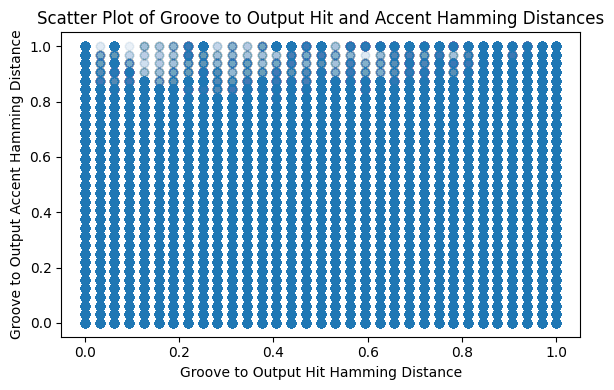

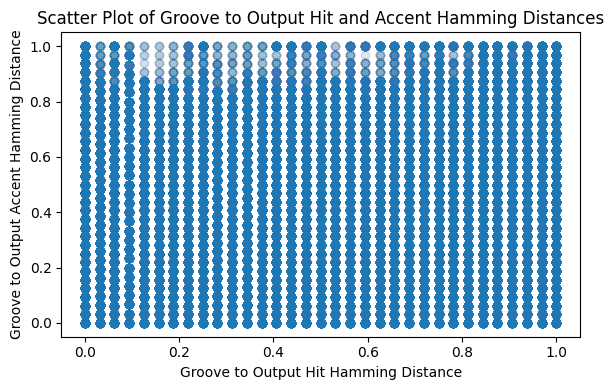

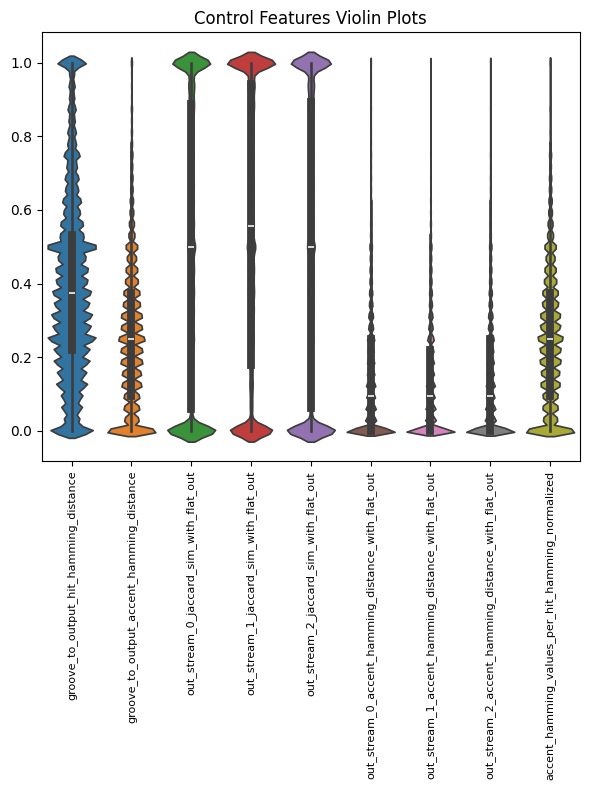

In [53]:
plot_scatter_input_output_distribution(control_features_df, use_normalized_accents=False)
plot_scatter_input_output_distribution(control_features_df, use_normalized_accents=True)
plot_control_features_violin(control_features_df)

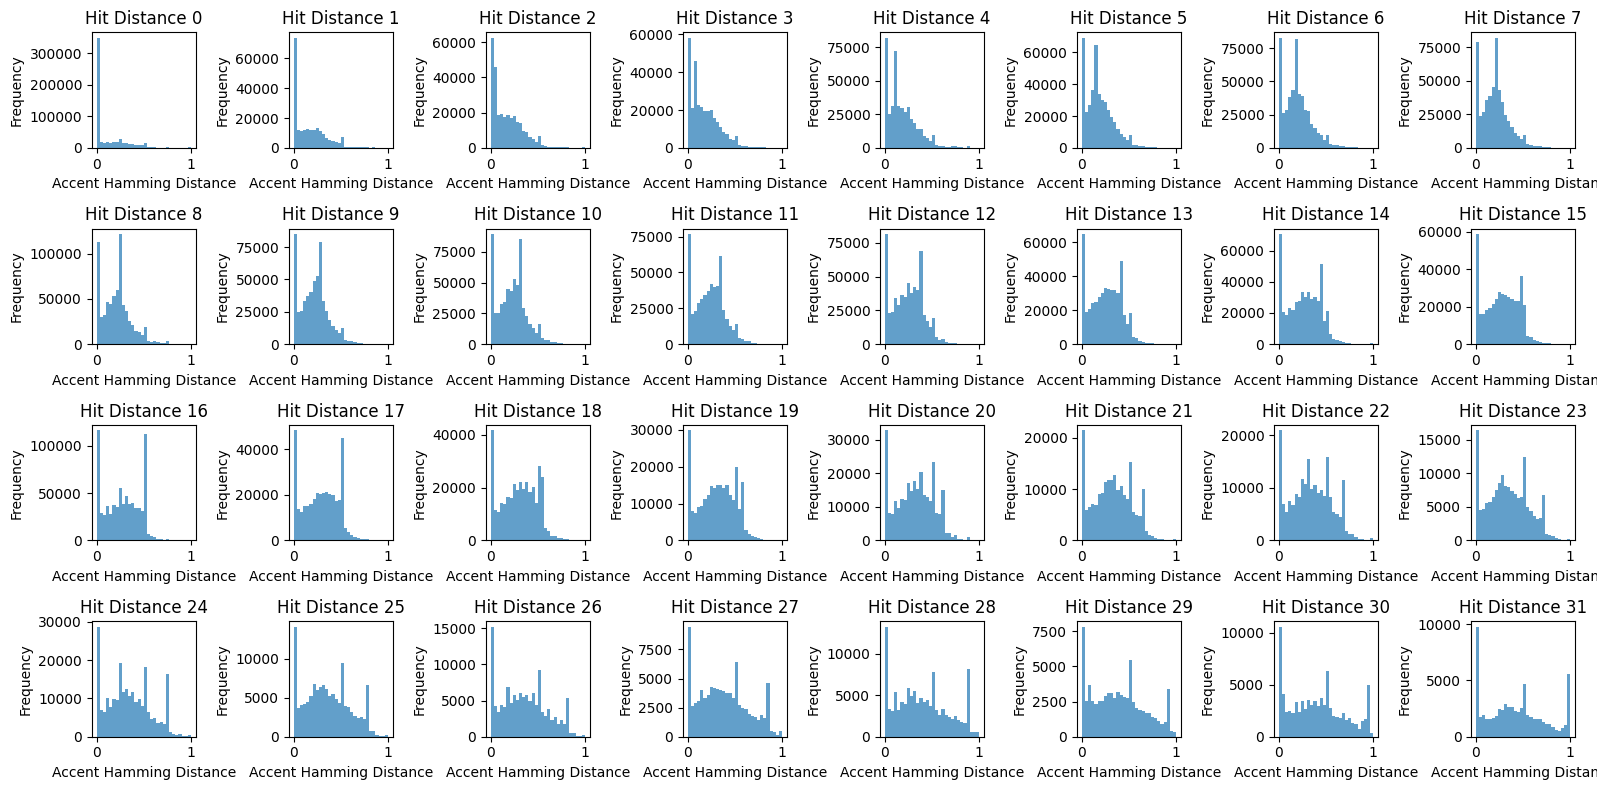

In [54]:
plot_histogram_accent_hamming_distance_grid(control_features_df, hit_hamming_distance_index=32)

In [55]:
create_heatmap_histogram(control_features_df,
                         key1="groove_to_output_hit_hamming_distance",
                         key2="groove_to_output_accent_hamming_distance",
                         bins=None,
                         title="Heatmap Histogram of Groove to Output Hit Hamming Distance vs Accent Hamming Distance",
                         )

## This is starting fresh - we can use this to rerun without the lakh for comparisons
#
#
#
#
#
#
### Just making this big

In [24]:
# # LOAD DATASETS

# data_dir = "data/triple_streams/split_2bars/rest" # "data/triple_streams/split_2bars/lmd"

# # find all .pkl.bz2 files in the directory
# dataset_pkls_mix = [f for f in os.listdir(data_dir) if f.endswith('.pkl.bz2')]

# # print the structure of each dataset
# print_all_datasets_structure(dataset_pkls_mix)

# # load all loops from all datasets
# split_n_bar_phrases_mix = get_split_n_bar_phrases(dataset_pkls_mix)

# # print the number of phrases loaded
# print(f"Number of split_n_bar_phrases loaded: {len(split_n_bar_phrases_mix)}")

In [25]:
# # Extract control features for all samples
# control_features_mix = {
#     "sample_id": [],
#     "collection": [],
# }
# control_features_static_groove_mix = {
#     "sample_id": [],
#     "collection": [],
# }
# import tqdm

# for hvo_sample in tqdm.tqdm(split_n_bar_phrases_mix):
#     for groove_dim in range(4): #<--- change to 1 if you don't want to use all streams as a groove (TODO: Change and generate different plots)
#         control_features_mix["sample_id"].append(hvo_sample.metadata['sample_id'])
#         control_features_mix["collection"].append(hvo_sample.metadata['collection'])

#         features = extract_features_from_sets(hvo_sample, groove_dim)
#         for key, value in features.items():
#             if key not in control_features_mix:
#                 control_features_mix[key] = []
#             control_features_mix[key].append(value)

# ### Same as above, but remove the range(4) -> keeps groove static
# ### using this for comparisons
# for hvo_sample in tqdm.tqdm(split_n_bar_phrases_mix):
#     for groove_dim in range(1): #<--- change to 1 if you don't want to use all streams as a groove (TODO: Change and generate different plots)
#         control_features_static_groove_mix["sample_id"].append(hvo_sample.metadata['sample_id'])
#         control_features_static_groove_mix["collection"].append(hvo_sample.metadata['collection'])

#         features = extract_features_from_sets(hvo_sample, groove_dim)
#         for key, value in features.items():
#             if key not in control_features_static_groove_mix:
#                 control_features_static_groove_mix[key] = []
#             control_features_static_groove_mix[key].append(value)


# # Convert to DataFrame
# import pandas as pd
# control_features_df_mix = pd.DataFrame(control_features_mix)
# control_features_df_mix


# control_features_static_groove_df_mix = pd.DataFrame(control_features_static_groove_mix)
# control_features_static_groove_df_mix

In [26]:
# import numpy as np
# # box plot import

# # get unique hit hamming distances
# hit_hamming_values = sorted(set(control_features_df_mix["groove_to_output_hit_hamming_distance"].values))
# print(hit_hamming_values)
# accent_hamming_values_per_hit_hamming = {float(hit_hamming_value): [] for hit_hamming_value in hit_hamming_values}
# for key in accent_hamming_values_per_hit_hamming.keys():
#     accent_hamming_values_per_hit_hamming[key] = control_features_df_mix[control_features_df_mix["groove_to_output_hit_hamming_distance"] == key].groove_to_output_accent_hamming_distance.values
#     # get box plot stats
#     lower_bound = np.sort(accent_hamming_values_per_hit_hamming[key])[10]
#     upper_bound = np.sort(accent_hamming_values_per_hit_hamming[key])[-30]
#     print(key, lower_bound, upper_bound)

#     if "accent_hamming_values_per_hit_hamming_normalized" not in control_features_df_mix.columns:
#         control_features_df_mix["accent_hamming_values_per_hit_hamming_normalized"] = np.nan

#     # stretch so that lower bound is 0 and upper bound is 1, then clip to 0-1 range
#     if lower_bound < 0.1:
#         lower_bound = 0.
#     control_features_df_mix.loc[control_features_df_mix["groove_to_output_hit_hamming_distance"] == key, "accent_hamming_values_per_hit_hamming_normalized"] = \
#         np.clip((control_features_df_mix.loc[control_features_df_mix["groove_to_output_hit_hamming_distance"] == key, "groove_to_output_accent_hamming_distance"] - lower_bound) / (upper_bound - lower_bound), 0, 1)

# # print new normalized column, vs original
# control_features_df_mix[["groove_to_output_hit_hamming_distance", "groove_to_output_accent_hamming_distance", "accent_hamming_values_per_hit_hamming_normalized"]].head(10)


In [27]:
# import numpy as np
# # box plot import

# # get unique hit hamming distances
# hit_hamming_values = sorted(set(control_features_static_groove_df_mix["groove_to_output_hit_hamming_distance"].values))
# print(hit_hamming_values)
# accent_hamming_values_per_hit_hamming = {float(hit_hamming_value): [] for hit_hamming_value in hit_hamming_values}
# for key in accent_hamming_values_per_hit_hamming.keys():
#     accent_hamming_values_per_hit_hamming[key] = control_features_static_groove_df_mix[control_features_static_groove_df_mix["groove_to_output_hit_hamming_distance"] == key].groove_to_output_accent_hamming_distance.values
#     # get box plot stats
#     lower_bound = np.sort(accent_hamming_values_per_hit_hamming[key])[10]
#     upper_bound = np.sort(accent_hamming_values_per_hit_hamming[key])[-30]
#     print(key, lower_bound, upper_bound)

#     if "accent_hamming_values_per_hit_hamming_normalized" not in control_features_static_groove_df_mix.columns:
#         control_features_static_groove_df_mix["accent_hamming_values_per_hit_hamming_normalized"] = np.nan

#     # strech so that lower bound is 0 and upper bound is 1, then clip to 0-1 range
#     if lower_bound < 0.1:
#         lower_bound = 0.
#     control_features_static_groove_df_mix.loc[control_features_static_groove_df_mix["groove_to_output_hit_hamming_distance"] == key, "accent_hamming_values_per_hit_hamming_normalized"] = \
#         np.clip((control_features_static_groove_df_mix.loc[control_features_static_groove_df_mix["groove_to_output_hit_hamming_distance"] == key, "groove_to_output_accent_hamming_distance"] - lower_bound) / (upper_bound - lower_bound), 0, 1)

# # print new normalized column, vs original
# control_features_static_groove_df_mix[["groove_to_output_hit_hamming_distance", "groove_to_output_accent_hamming_distance", "accent_hamming_values_per_hit_hamming_normalized"]].head(10)


In [28]:
# plot_scatter_input_output_distribution_for_dataset(control_features_df_mix, 'lmd_batch_05', use_normalized_accents=True)

In [29]:
# plot_scatter_input_output_distribution_for_dataset(control_features_df_mix, 'lmd_batch_04', use_normalized_accents=True)

In [30]:
# # Create boxplot
# sns.boxplot(x='collection', y='accent_hamming_values_per_hit_hamming_normalized', data=control_features_df_mix)
# plt.xticks(rotation=90)
# plt.title('Accent Hamming Values Normalized')
# plt.show()

In [31]:
# plot_scatter_input_output_distribution(control_features_df_mix, use_normalized_accents=True)

We're going to need to figure out what to do with these spikes around the 0 mark
1. We can scrub the data - this might be more difficult as we move the hamming distance for the hits up (see charts "Hit Distance" 23 and 25 - 30)
2. Question - if we leave as is, we have a lot of data that we're trainging on. So, the model is going to be biased towards certain values (e.g. (0,0)) - is this a huge problem? Like, what happens is we train on this? Does shit still work like we expect-ish????
3. Should we try to create more data in a certain way to give us what we would like? -> Do we have time for this???
4. Look at lakh, grooveMidi, etc... We should be able to inspect the metadata.. maybe we can remove some of the combinations that make this not work as well. Like, hi/mid/lo - > we flatten the three to make the groove, so maybe we only use half of these?????


In [32]:
# plot_histogram_accent_hamming_distance_grid(control_features_df_mix, hit_hamming_distance_index=32)

Don't modify anything below this line. We need to keep track of how much things are modifed with the addition of more LAKH data

In [33]:
#plot_scatter_input_output_distribution_for_dataset(control_features_df_mix, 'lmd_batch_03', use_normalized_accents=True)

In [34]:
# plot_scatter_input_output_distribution_for_dataset(control_features_df_mix, 'lmd_batch_02', use_normalized_accents=True)

In [35]:
# # Create boxplot
# sns.boxplot(x='collection', y='accent_hamming_values_per_hit_hamming_normalized', data=control_features_df_mix)
# plt.xticks(rotation=90)
# plt.title('Accent Hamming Values Normalized')
# plt.show()

In [36]:
# plot_scatter_input_output_distribution(control_features_df_mix, use_normalized_accents=True)

In [37]:
# plot_histogram_accent_hamming_distance_grid(control_features_df_mix, hit_hamming_distance_index=32)

Don't modify anything below this line. We need to keep track of how much things are modifed with the addition of more LAKH data

In [38]:
#plot_scatter_input_output_distribution_for_dataset(control_features_df_mix, 'lmd_batch_01', use_normalized_accents=True)

In [39]:
#plot_scatter_input_output_distribution_for_dataset(control_features_df_mix, 'lmd_batch_01', use_normalized_accents=False)

In [40]:
# # Create boxplot
# sns.boxplot(x='collection', y='accent_hamming_values_per_hit_hamming_normalized', data=control_features_df_mix)
# plt.xticks(rotation=90)
# plt.title('Accent Hamming Values Normalized')
# plt.show()

In [41]:
# plot_scatter_input_output_distribution(control_features_df_mix, use_normalized_accents=True)

In [42]:
# plot_histogram_accent_hamming_distance_grid(control_features_df_mix, hit_hamming_distance_index=32)

In [43]:
print(control_features_df_mix['collection'].unique())

NameError: name 'control_features_df_mix' is not defined